<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-model" data-toc-modified-id="Load-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load model</a></span></li><li><span><a href="#Lime" data-toc-modified-id="Lime-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lime</a></span><ul class="toc-item"><li><span><a href="#1st-Example---hit" data-toc-modified-id="1st-Example---hit-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>1st Example - hit</a></span></li><li><span><a href="#2nd-Example---decoy" data-toc-modified-id="2nd-Example---decoy-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2nd Example - decoy</a></span></li><li><span><a href="#3rd-example---hit" data-toc-modified-id="3rd-example---hit-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>3rd example - hit</a></span></li><li><span><a href="#Aggregate-view" data-toc-modified-id="Aggregate-view-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Aggregate view</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import pdb
from argparse import ArgumentParser
import shlex
from tqdm import tqdm

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import pMHC
from pMHC import SEP, \
    SPLITS, SPLIT_TRAIN, SPLIT_VAL, SPLIT_TEST, \
    VIEWS, VIEW_SA, VIEW_SAMA, VIEW_DECONV, \
    INPUT_PEPTIDE, INPUT_CONTEXT
from pMHC.logic import PresentationPredictor
from pMHC.data import from_data, to_input
from pMHC.data.example import Observation, Decoy
from pMHC.data.mhc_allele import MhcAllele

tqdm.pandas()

In [2]:
import torch
import pickle

from pMHC.data import pseudo_pos
from pMHC.interpret.lime_based import MyExplainer, lime_analysis, stacked_bar_charts
from pMHC.interpret.utils import show_MHC
from pMHC.data.utils import convert_example_to_batch, move_dict_to_device

from pytorch_lightning.utilities.seed import seed_everything

In [3]:
pMHC.set_paths(r"C:\Users\tux\Documents\MScProject")

Update project folder to: C:\Users\tux\Documents\MScProject
Load permutation


# Load model

In [4]:
version = "CONTEXT-PSEUDO-HEAD_Cls-DECOY_19-LR_0.00001"
checkpoint = "epoch=4-step=3648186"

In [5]:
MODEL_PATH = f"{pMHC.OUTPUT_FOLDER}{SEP}main{SEP}{version}{SEP}checkpoints{SEP}{checkpoint}.ckpt"
model = PresentationPredictor.load_from_checkpoint(MODEL_PATH,
                                                   num_workers=0, shuffle_data=False, output_attentions=False)
    
model.setup()

model.to("cuda");
model.eval();

Global seed set to 42
Global seed set to 42


PresentationPredictor.setup: 2021-08-12 19:22:16
MhcAllele.from_input


MhcAlleles from input: 11074it [00:00, 16040.36it/s]


Protein.from_input


Proteins from input: 185930it [00:11, 16019.92it/s]


Sample.from_input


Samples from input: 472it [00:00, 15090.18it/s]


Peptide.from_input


Peptides from input: 429339it [00:27, 15458.03it/s]


Observation.from_input


Observations from input: 1959736it [02:01, 16102.50it/s]
100%|████████████████████████████████████████████████████████████████████| 1959736/1959736 [00:08<00:00, 239875.16it/s]


Decoy.to_input
Load decoys for 1959737 observations
decoys_0_50000.csv
decoys_1000000_1050000.csv
decoys_100000_150000.csv
decoys_1050000_1100000.csv
decoys_1100000_1150000.csv
decoys_1150000_1200000.csv
decoys_1200000_1250000.csv
decoys_1250000_1300000.csv
decoys_1300000_1350000.csv
decoys_1350000_1400000.csv
decoys_1400000_1450000.csv
decoys_1450000_1500000.csv
decoys_1500000_1550000.csv
decoys_150000_200000.csv
decoys_1550000_1600000.csv
decoys_1600000_1650000.csv
decoys_1650000_1700000.csv
decoys_1700000_1750000.csv
decoys_1750000_1800000.csv
decoys_1800000_1850000.csv
decoys_1850000_1900000.csv
decoys_1900000_1950000.csv
decoys_1950000_2000000.csv
decoys_200000_250000.csv
decoys_250000_300000.csv
decoys_300000_350000.csv
decoys_350000_400000.csv
decoys_400000_450000.csv
decoys_450000_500000.csv
decoys_500000_550000.csv
decoys_50000_100000.csv
decoys_550000_600000.csv
decoys_600000_650000.csv
decoys_650000_700000.csv
decoys_700000_750000.csv
decoys_750000_800000.csv
decoys_800000_8

Global seed set to 42


PresentationPredictor.setup finished: 2021-08-12 19:32:22


Datasources

OBSERVATIONS                        /   MHC/Obs comb
   Edi                 :  1,550,250 /      7,209,446
   Atlas               :    409,486 /      2,436,897
   TOTAL               :  1,959,736 /      9,646,343




Splits

OBSERVATIONS                          SA            SAMA          Deconv
   train               :          205,591       1,407,876       6,734,816
   val                 :           33,920         274,378       1,299,848
   test                :           53,823         277,482       1,318,345
   val-prot            :           10,149          70,072         335,832
   test-prot           :           11,056          71,150         336,955
   val-mhc             :           23,771         204,306         964,016
   test-mhc            :           42,767         206,332         981,390



Dataloaders

EXAMPLES

   train               
      SA               :  4,111,820 /        128,494
      SAM

# Lime

In [7]:
num_samples = 10000

explainer = MyExplainer()

## 1st Example - hit

In [38]:
idx = 0
example = model.ds[SPLIT_TRAIN][idx]
pred = float(torch.sigmoid(model(move_dict_to_device(convert_example_to_batch(example), model))))

print(f"{example['objects'][0].get_decoy(example['objects'][2]).peptide_seq}: {pred:.3f}")

LEDLNFPEI: 0.912


In [11]:
exp = explainer.explain_instance(
    example, 
    model,  
    explain_peptide=True, explain_context=True,
    batch_size=model.batch_size, 
    num_samples=num_samples)

batch: 100 (3200 of 10000)
batch: 200 (6400 of 10000)
batch: 300 (9600 of 10000)


In [12]:
feature_importances = exp.as_list()

In [13]:
Observation.obs_views[SPLIT_TRAIN][model.view][idx].peptide_seq

'LEDLNFPEI'

In [14]:
feature_importances

[('I_peptide_9', 0.20135333498299593),
 ('E_peptide_2', 0.18739201853066387),
 ('W_MHC_95', 0.13658386846561796),
 ('D_peptide_3', -0.09669887663580336),
 ('P_peptide_7', 0.07505845800204487),
 ('K_MHC_45', 0.07314539425512041),
 ('F_peptide_6', 0.06556841423073695),
 ('L_peptide_1', -0.06009192427358653),
 ('H_MHC_9', 0.05666120699071238),
 ('L_peptide_4', -0.05320908973217946),
 ('L_MHC_116', 0.05181149599079069),
 ('T_MHC_24', 0.051625989386006994),
 ('R_MHC_97', 0.045254795148421144),
 ('I_MHC_80', 0.04354898829305224),
 ('L_MHC_156', 0.04166538778522131),
 ('A_MHC_81', 0.037632990881009874),
 ('N_MHC_77', 0.03717079390094135),
 ('L_MHC_163', 0.027587751341388796),
 ('N_MHC_70', 0.026101857973561758),
 ('Y_MHC_99', 0.025121011385620166),
 ('Y_MHC_84', 0.024443814032478924),
 ('Y_MHC_74', 0.02216814180756272),
 ('N_peptide_5', -0.02212193805246222),
 ('M_C-flank_5', -0.02121169312899918),
 ('N_MHC_114', 0.018008712090614675),
 ('G_N-flank_4', -0.017264769921944766),
 ('T_MHC_73', 0.

## 2nd Example - decoy

In [39]:
idx = 1
example = model.ds[SPLIT_TRAIN][idx]
pred = float(torch.sigmoid(model(move_dict_to_device(convert_example_to_batch(example), model))))

print(f"{example['objects'][0].get_decoy(example['objects'][2]).peptide_seq}: {pred:.3f}")

LNAIIGVRG: 0.000


In [40]:
exp = explainer.explain_instance(
    example, 
    model,  
    explain_peptide=True, explain_context=True,
    batch_size=12, 
    num_samples=num_samples)

batch: 100 (1200 of 10000)
batch: 200 (2400 of 10000)
batch: 300 (3600 of 10000)
batch: 400 (4800 of 10000)
batch: 500 (6000 of 10000)
batch: 600 (7200 of 10000)
batch: 700 (8400 of 10000)
batch: 800 (9600 of 10000)


In [41]:
feature_importances = exp.as_list()

In [42]:
feature_importances

[('G_peptide_9', -0.00648711211652457),
 ('N_peptide_2', -0.002467538584616331),
 ('L_peptide_1', -0.002466464184183648),
 ('R_peptide_8', -0.0024119344867876953),
 ('E_N-flank_1', 0.0016081482087671446),
 ('A_N-flank_2', 0.0015733653353363355),
 ('T_MHC_24', -0.001202756601889181),
 ('P_C-flank_2', -0.0008079246444918335),
 ('I_peptide_4', -0.0007603061747525063),
 ('H_C-flank_15', 0.0007037820515716855),
 ('A_N-flank_14', 0.000664909173964329),
 ('M_N-flank_3', -0.0006431462819213851),
 ('V_peptide_7', -0.0005370302971253774),
 ('Q_C-flank_14', 0.0005342934533029834),
 ('S_MHC_67', -0.0005340652179061143),
 ('I_peptide_5', -0.0004938896586218645),
 ('Y_MHC_74', 0.00046453794828198213),
 ('A_C-flank_13', 0.00043543292299695467),
 ('Y_MHC_59', -0.00043486463475923387),
 ('A_N-flank_12', 0.00043115775593868116),
 ('E_MHC_152', -0.00042643436706774914),
 ('Y_MHC_7', 0.00042478117424139925),
 ('A_peptide_3', -0.00042247523265089633),
 ('Q_N-flank_13', 0.00037277124943876455),
 ('K_MHC_45'

## 3rd example - hit

In [44]:
idx = 100
example = model.ds[SPLIT_TRAIN][idx]
pred = float(torch.sigmoid(model(move_dict_to_device(convert_example_to_batch(example), model))))

print(f"{example['objects'][0].get_decoy(example['objects'][2]).peptide_seq}: {pred:.3f}")

LYDLTLEYL: 0.945


In [45]:
exp = explainer.explain_instance(
    example, 
    model,  
    explain_peptide=True, explain_context=True,
    batch_size=12, 
    num_samples=num_samples)

batch: 100 (1200 of 10000)
batch: 200 (2400 of 10000)
batch: 300 (3600 of 10000)
batch: 400 (4800 of 10000)
batch: 500 (6000 of 10000)
batch: 600 (7200 of 10000)
batch: 700 (8400 of 10000)
batch: 800 (9600 of 10000)


In [46]:
feature_importances = exp.as_list()

In [47]:
feature_importances

[('D_peptide_3', 0.4644212215193127),
 ('Y_peptide_2', 0.37874957883386534),
 ('L_peptide_9', 0.2558767835535414),
 ('L_peptide_1', -0.06479884813354406),
 ('Y_peptide_8', -0.047873111804953856),
 ('L_peptide_4', -0.046459800674558974),
 ('T_peptide_5', 0.03845404242778559),
 ('Q_N-flank_1', -0.03486703083531488),
 ('R_MHC_97', 0.03466318194737072),
 ('R_MHC_156', 0.03145635062419075),
 ('E_peptide_7', 0.02765358554108293),
 ('N_MHC_114', 0.022308728236444256),
 ('N_N-flank_14', 0.01744281135454112),
 ('L_peptide_6', -0.0152680952501285),
 ('F_MHC_116', 0.014202243939868124),
 ('G_MHC_45', 0.011852327681814961),
 ('K_MHC_80', 0.010817819559285955),
 ('N_MHC_77', 0.010582214749193545),
 ('E_N-flank_11', 0.010437049734087024),
 ('A_N-flank_9', 0.009499236123521762),
 ('F_MHC_99', -0.0092937762260609),
 ('Q_N-flank_12', 0.009257916152069624),
 ('S_MHC_9', 0.009207252430424183),
 ('R_MHC_69', 0.008877744175650265),
 ('W_MHC_167', -0.008839924342259779),
 ('L_C-flank_14', -0.008696343205311

## Aggregate view

In [6]:
num_samples = 2000
model.view = VIEW_SA
peptide_length = 9
obs_per_allele = 500
decoys_per_obs = 1
examples_dict = {"HLA-A33:01": [], "HLA-A33:03": [], "HLA-A36:01": [], "HLA-A74:01": [], 
                "HLA-B37:01": [], "HLA-B46:01": [], "HLA-B54:01": [], "HLA-B58:01": [], "HLA-B58:02": [],
                "HLA-C01:02": [], "HLA-C15:02": [], "HLA-C17:01": []}

mhc_allele_names = list(examples_dict.keys())
for obs in Observation.observations:
    if len(obs.sample.mhc_alleles) == 1 \
            and obs.mhc_allele.name in mhc_allele_names \
            and len(obs.peptide_seq) == 9:
        examples_dict[obs.mhc_allele.name].append(obs)
        
seed_everything(42)
for key, item in examples_dict.items():
    print(f"{key}: {len(item)}")
    examples_dict[key] = np.random.choice(item, obs_per_allele)
    print(f"selected hits {key}: {len(examples_dict[key])}")
    examples_dict[key] = np.concatenate([examples_dict[key], 
        [obs.get_example(decoy_idx) for decoy_idx in np.random.choice(range(99), decoys_per_obs)
                                    for obs in examples_dict[key]]])
    print(f"selected all {key}: {len(examples_dict[key])}")
    

Global seed set to 42


HLA-A33:01: 1945
selected hits HLA-A33:01: 500
selected all HLA-A33:01: 1000
HLA-A33:03: 1978
selected hits HLA-A33:03: 500
selected all HLA-A33:03: 1000
HLA-A36:01: 971
selected hits HLA-A36:01: 500
selected all HLA-A36:01: 1000
HLA-A74:01: 1476
selected hits HLA-A74:01: 500
selected all HLA-A74:01: 1000
HLA-B37:01: 1016
selected hits HLA-B37:01: 500
selected all HLA-B37:01: 1000
HLA-B46:01: 828
selected hits HLA-B46:01: 500
selected all HLA-B46:01: 1000
HLA-B54:01: 532
selected hits HLA-B54:01: 500
selected all HLA-B54:01: 1000
HLA-B58:01: 1273
selected hits HLA-B58:01: 500
selected all HLA-B58:01: 1000
HLA-B58:02: 806
selected hits HLA-B58:02: 500
selected all HLA-B58:02: 1000
HLA-C01:02: 2861
selected hits HLA-C01:02: 500
selected all HLA-C01:02: 1000
HLA-C15:02: 5823
selected hits HLA-C15:02: 500
selected all HLA-C15:02: 1000
HLA-C17:01: 2453
selected hits HLA-C17:01: 500
selected all HLA-C17:01: 1000


explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:34:30<00:00,  5.67s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


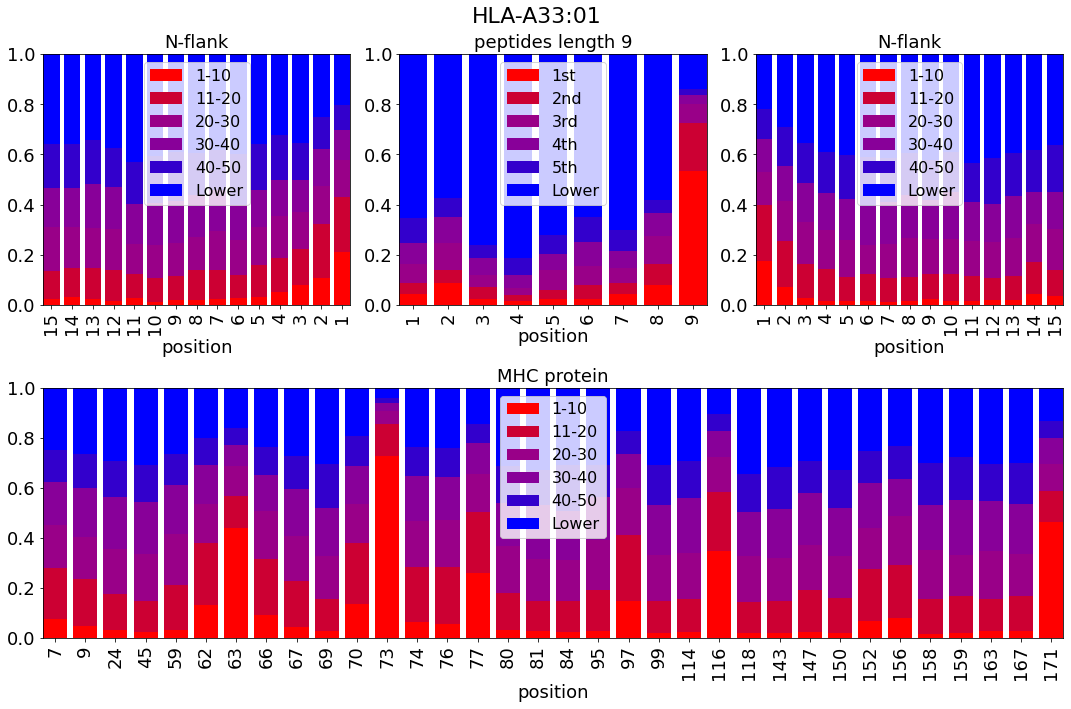

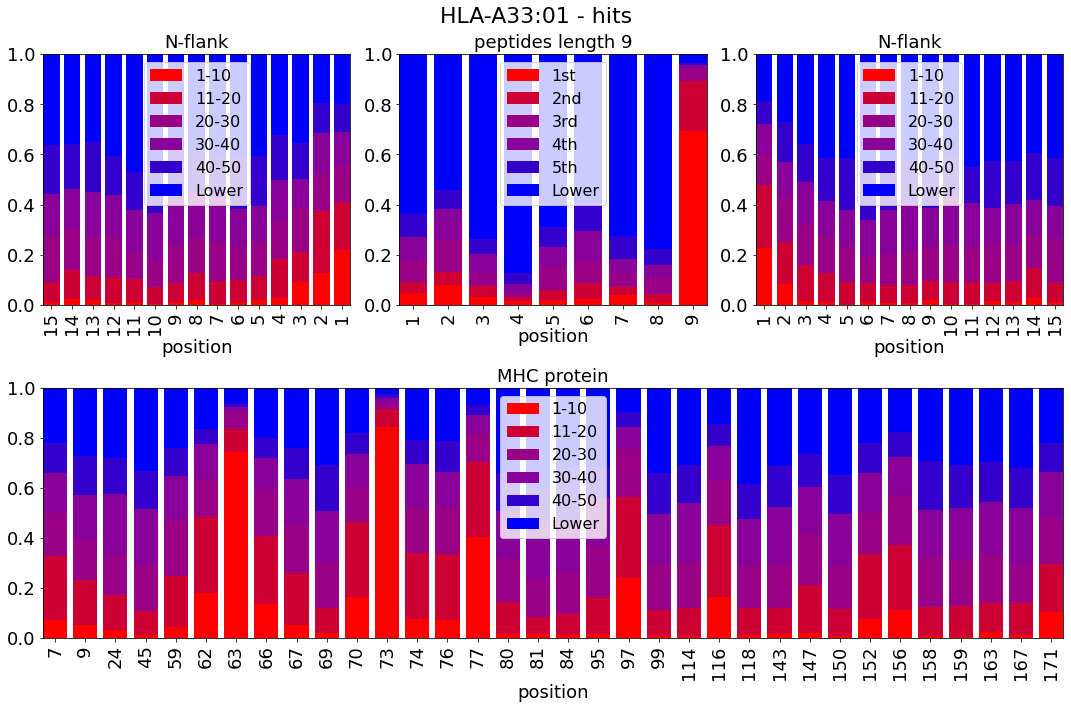

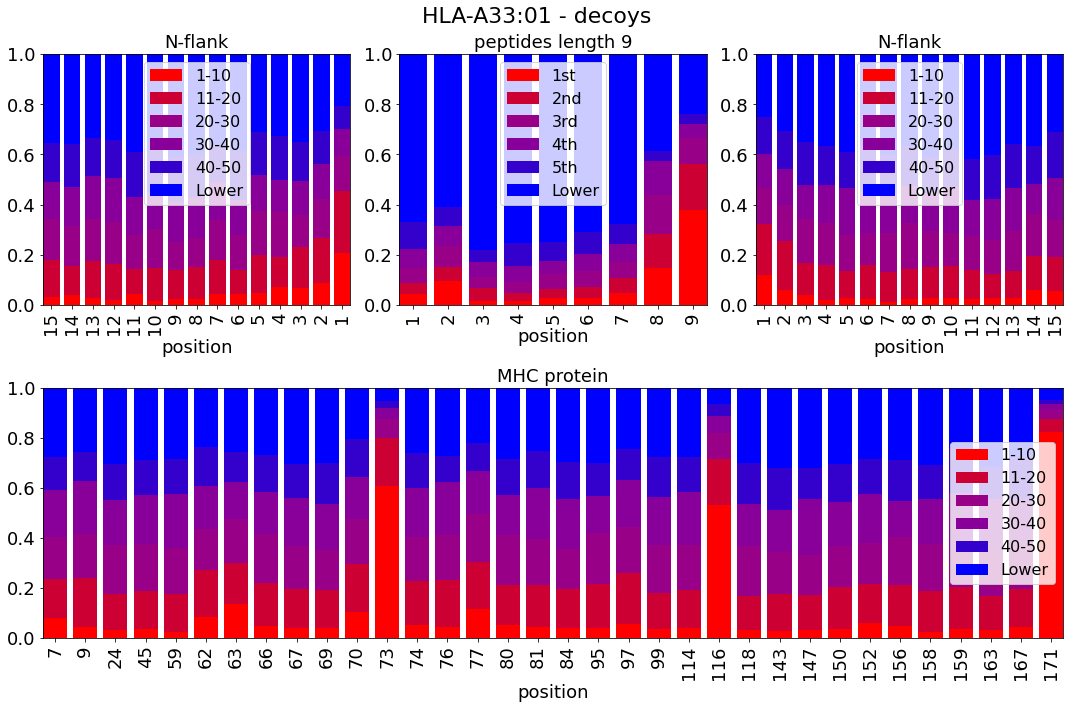

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:32:50<00:00,  5.57s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


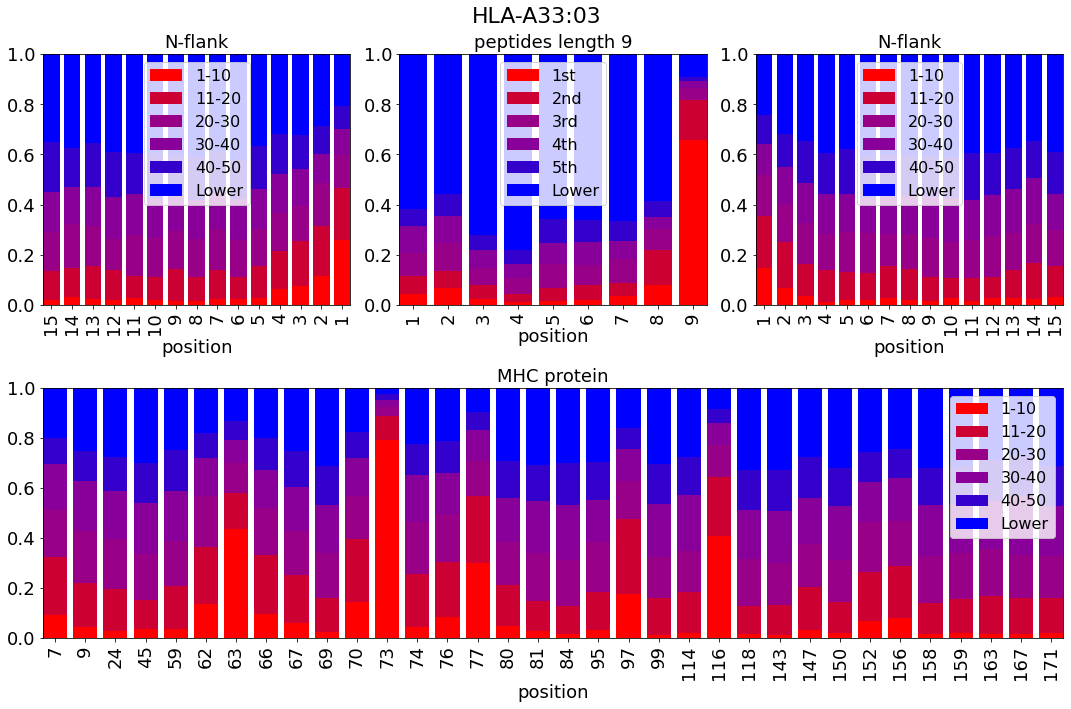

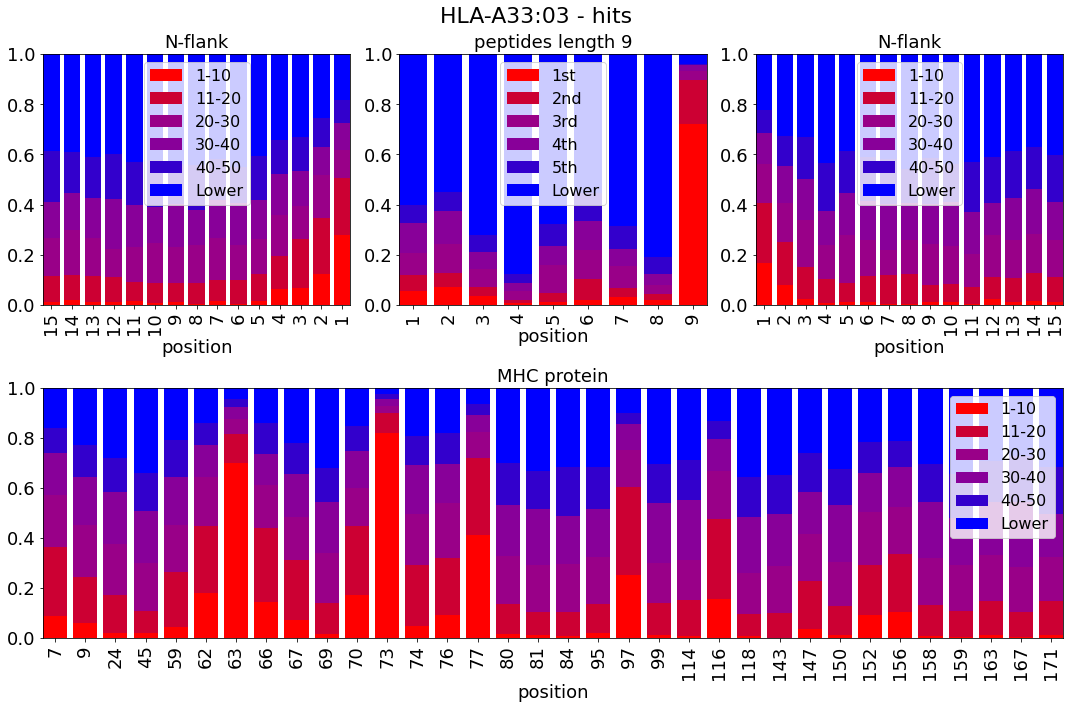

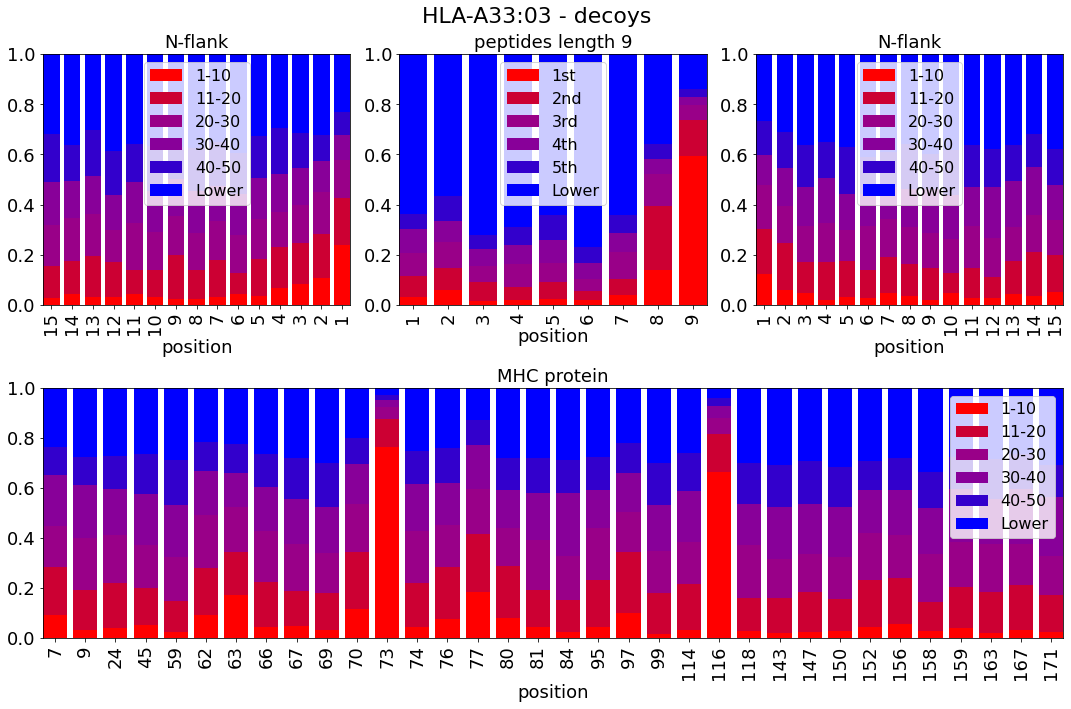

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:34:41<00:00,  5.68s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


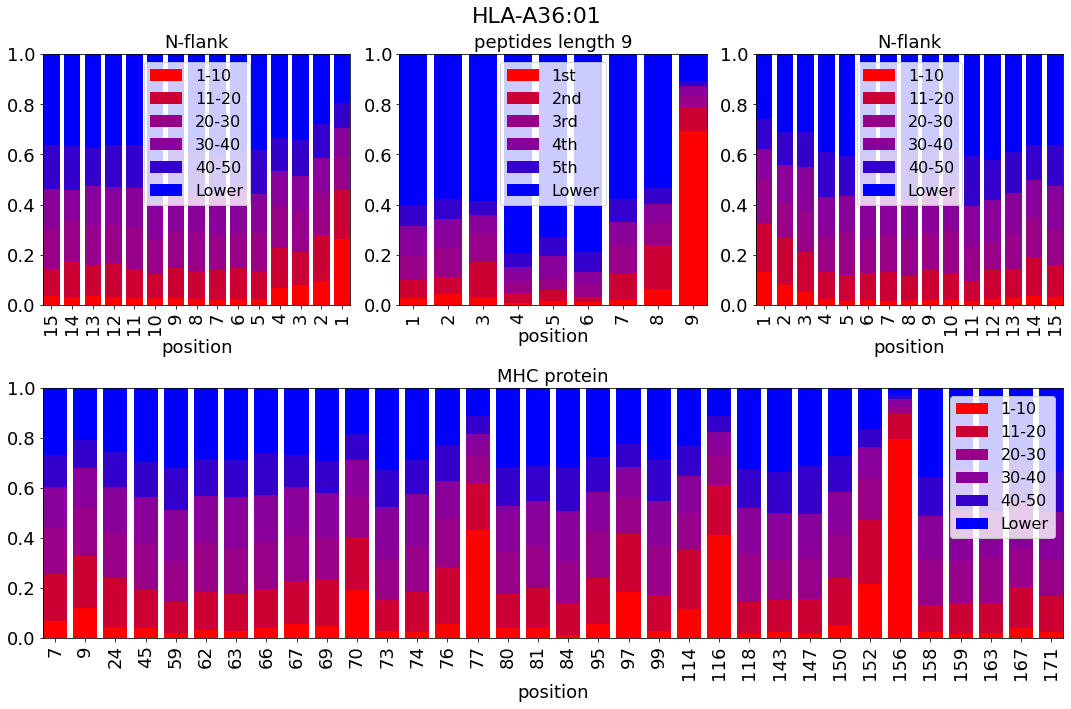

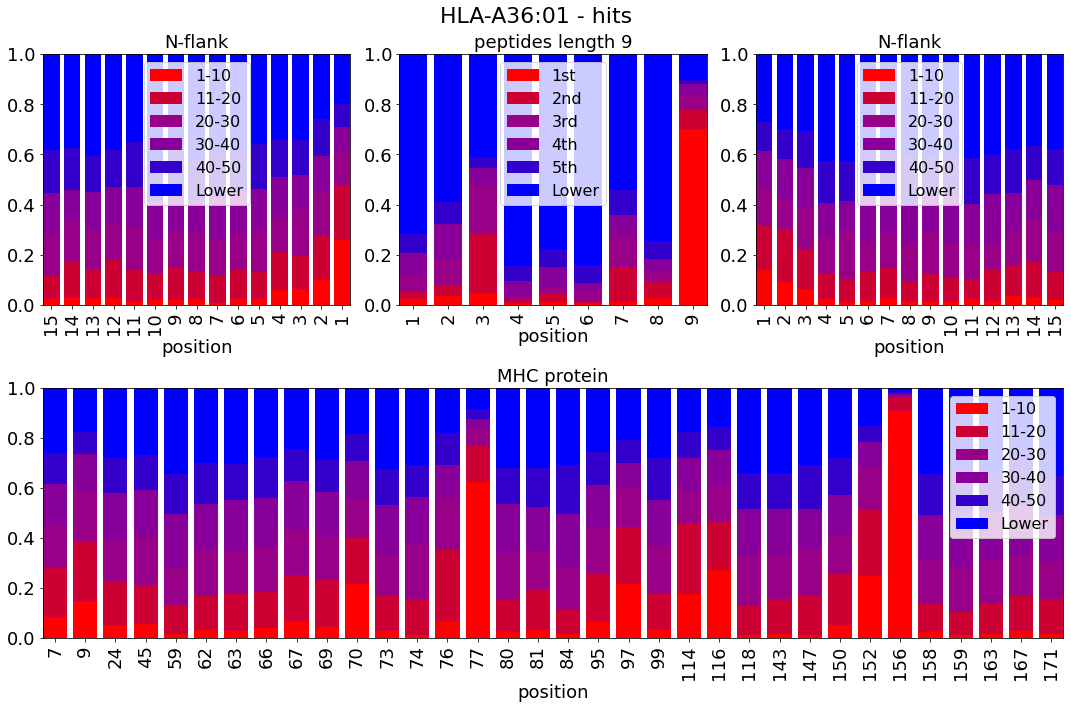

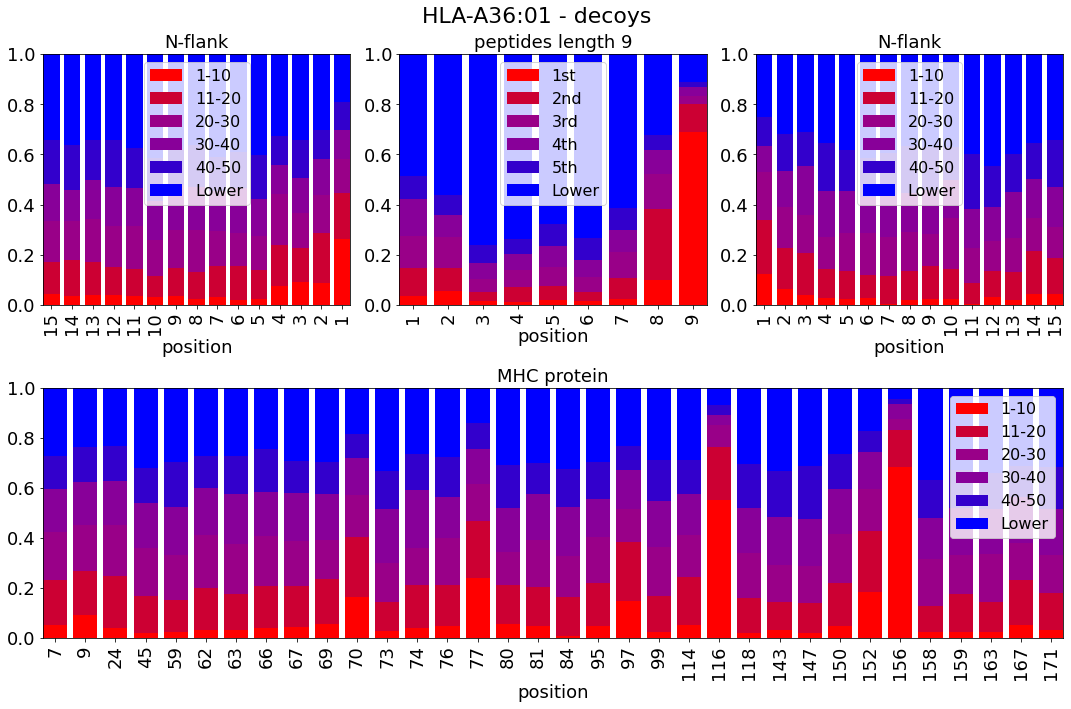

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:32:48<00:00,  5.57s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


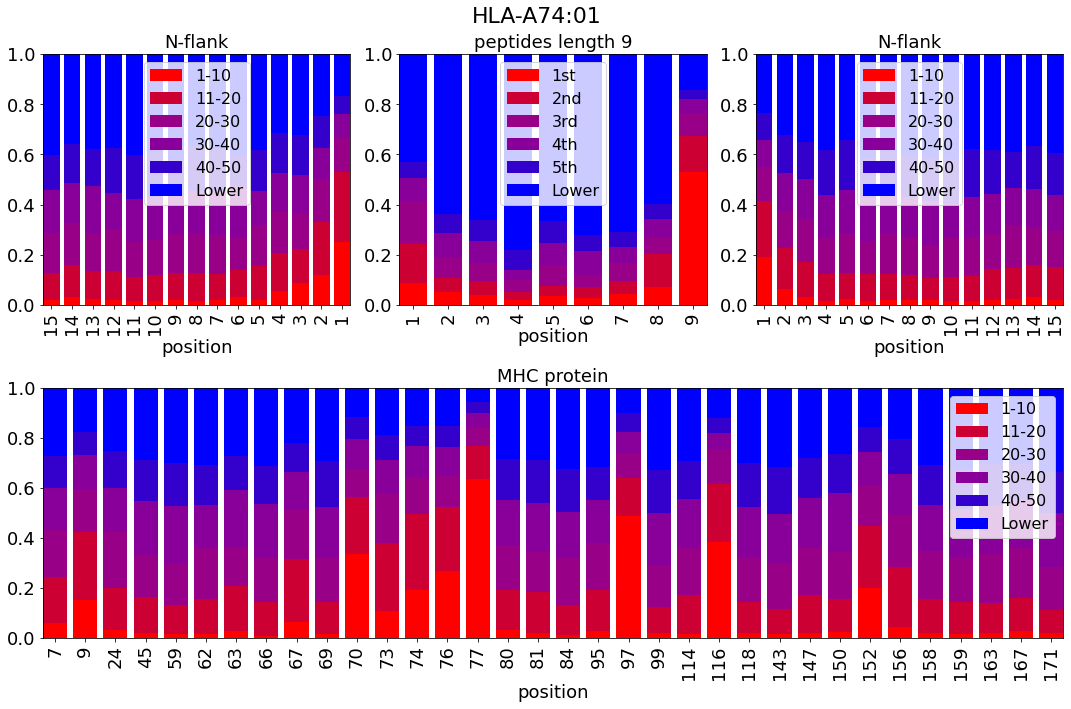

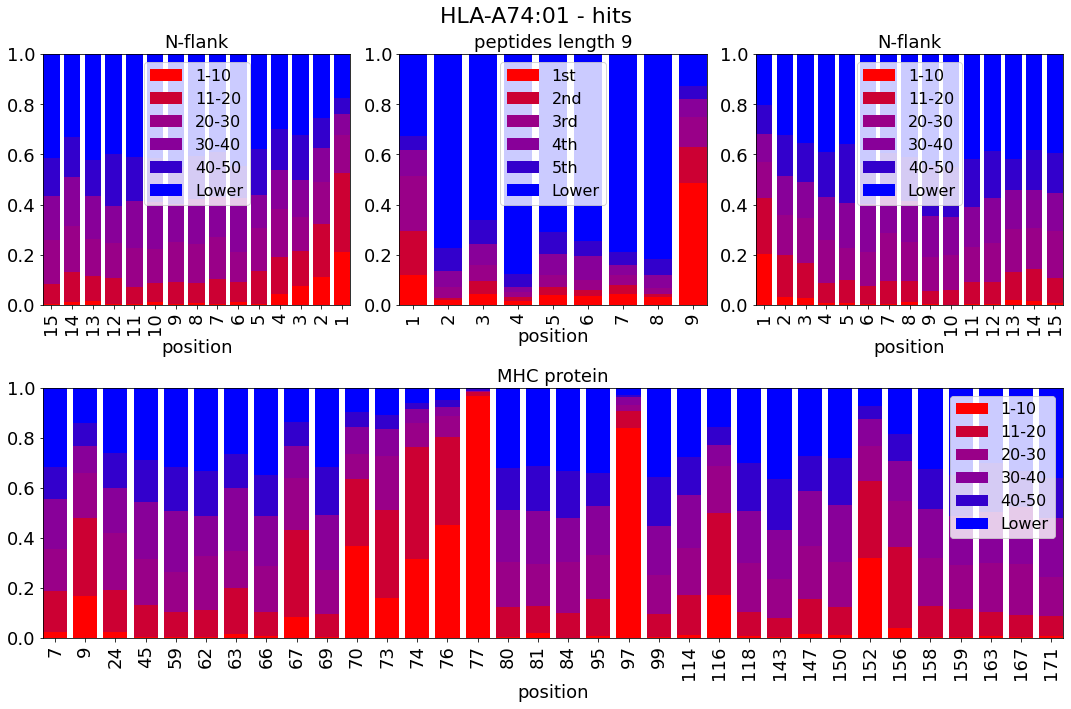

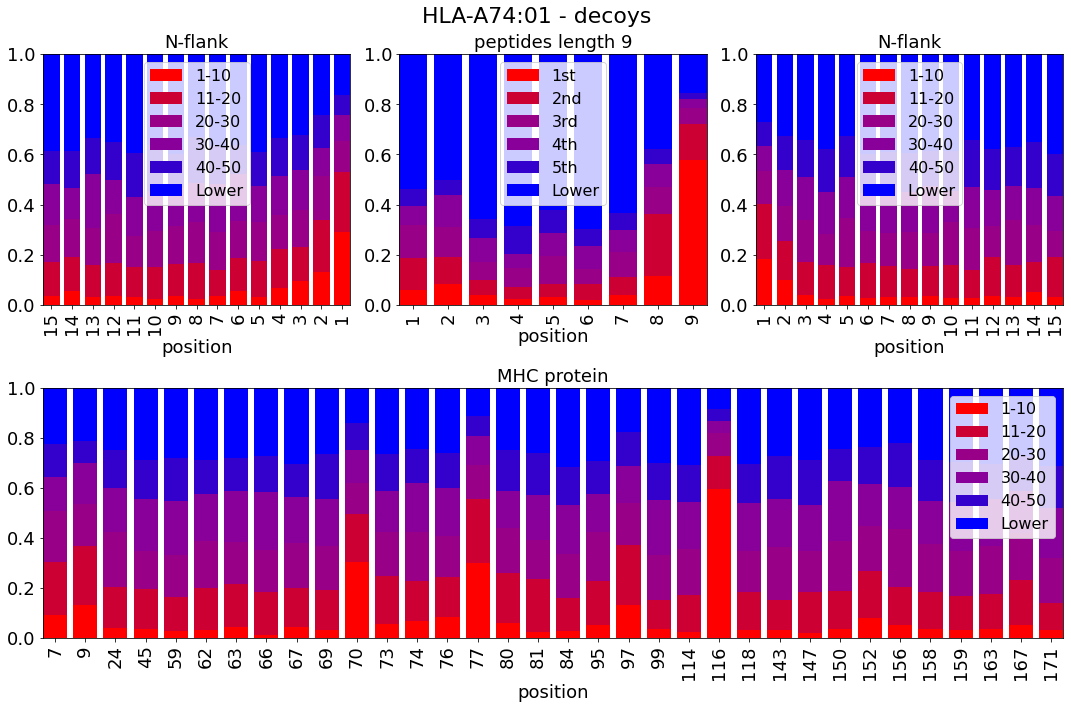

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:33:54<00:00,  5.63s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


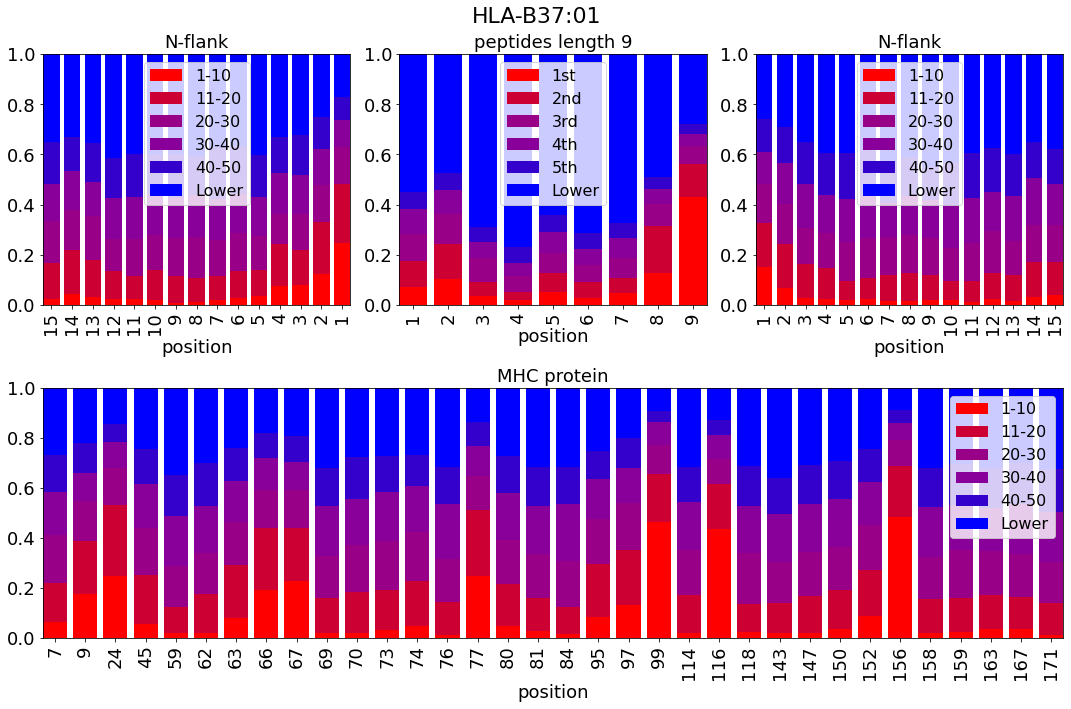

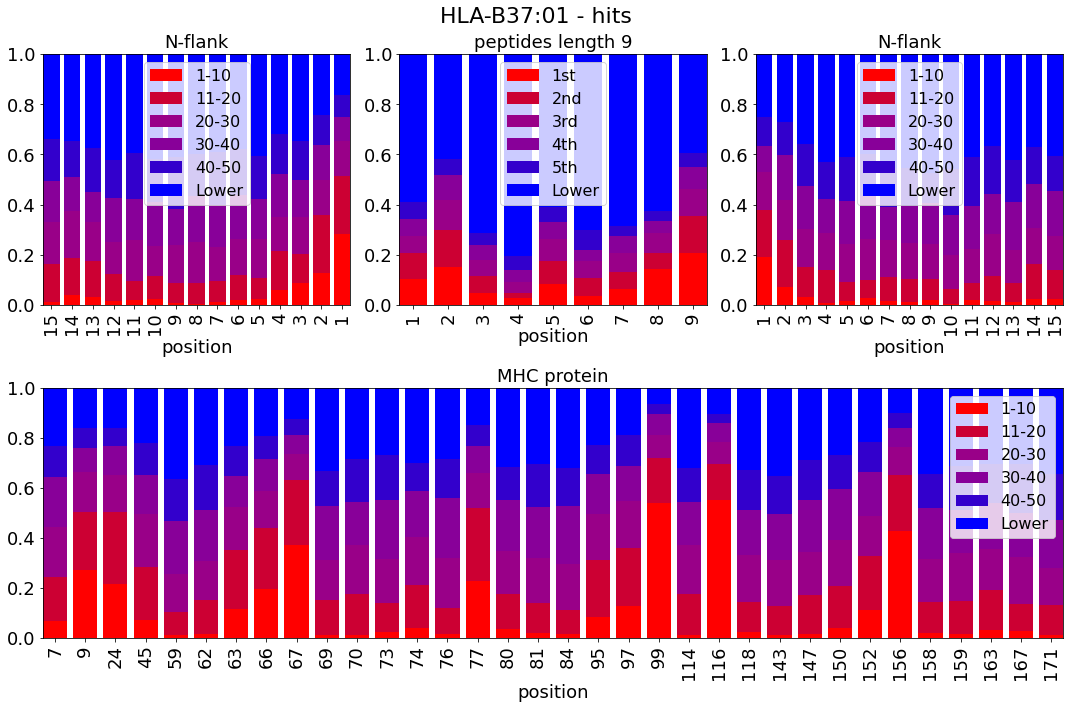

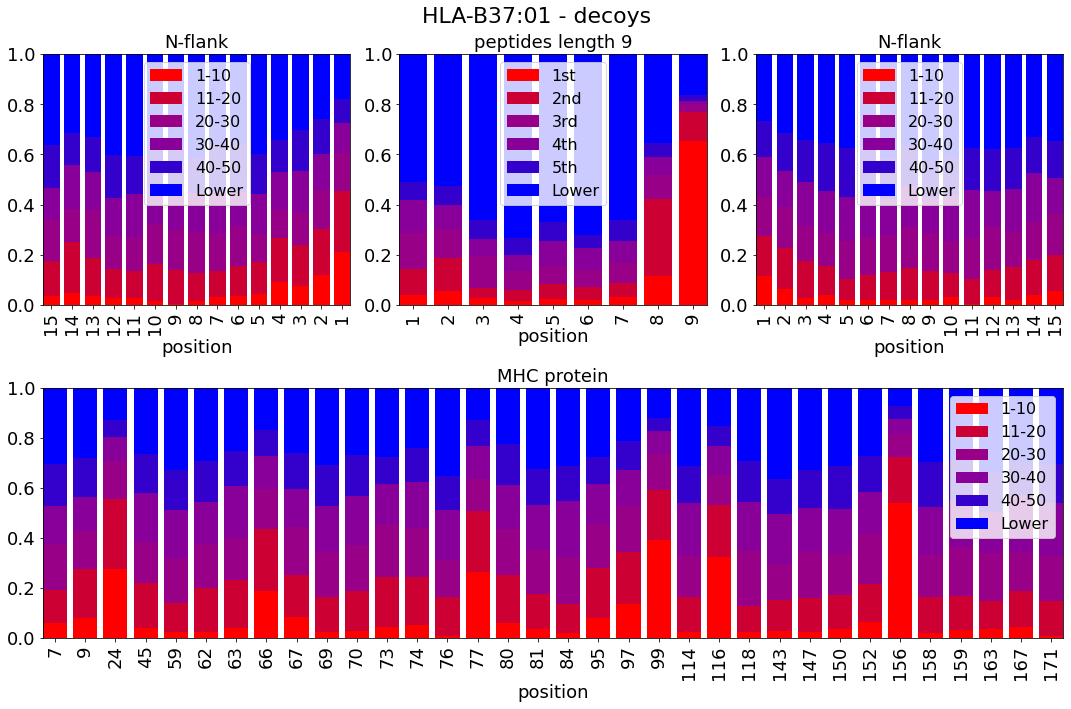

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:31:41<00:00,  5.50s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


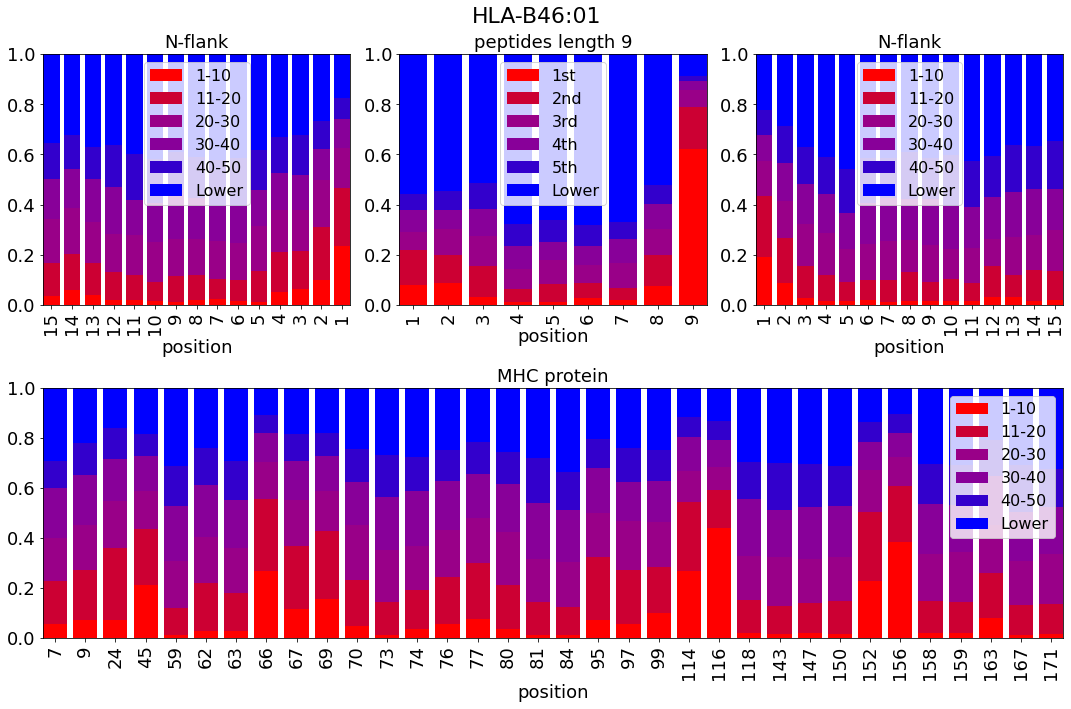

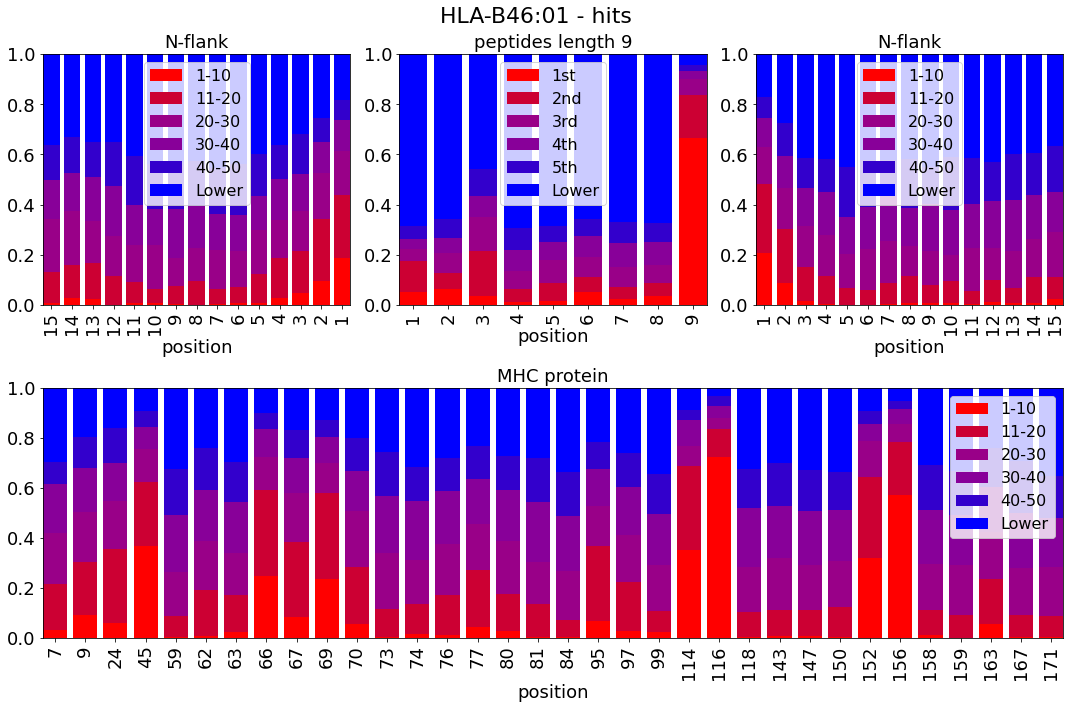

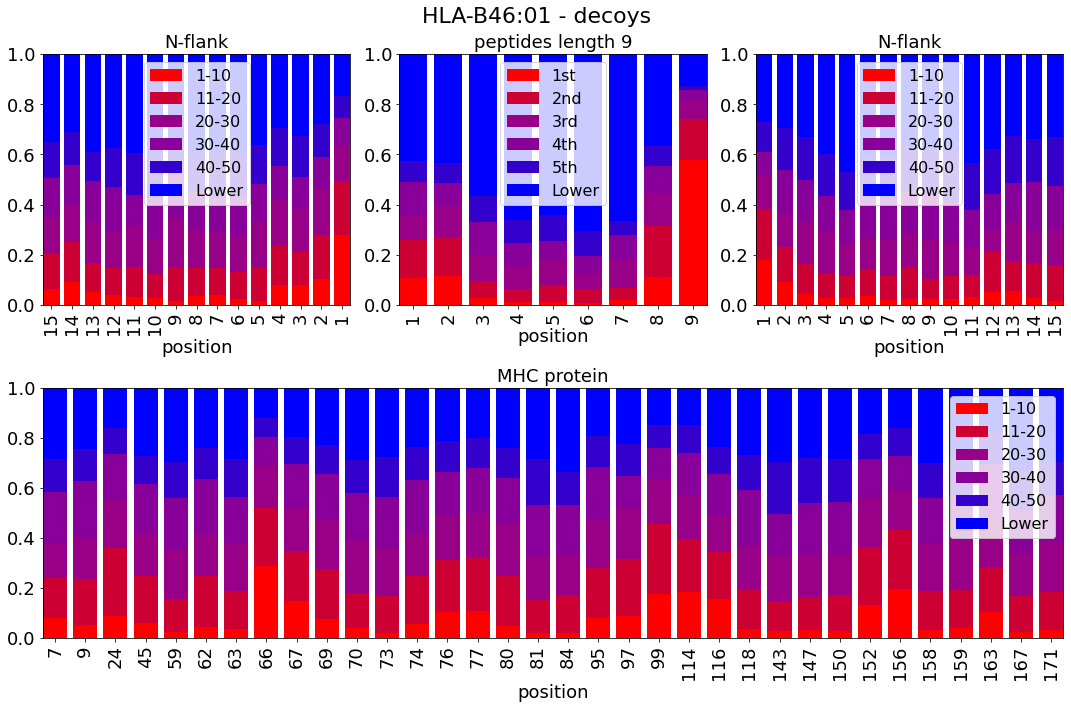

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:30:27<00:00,  5.43s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


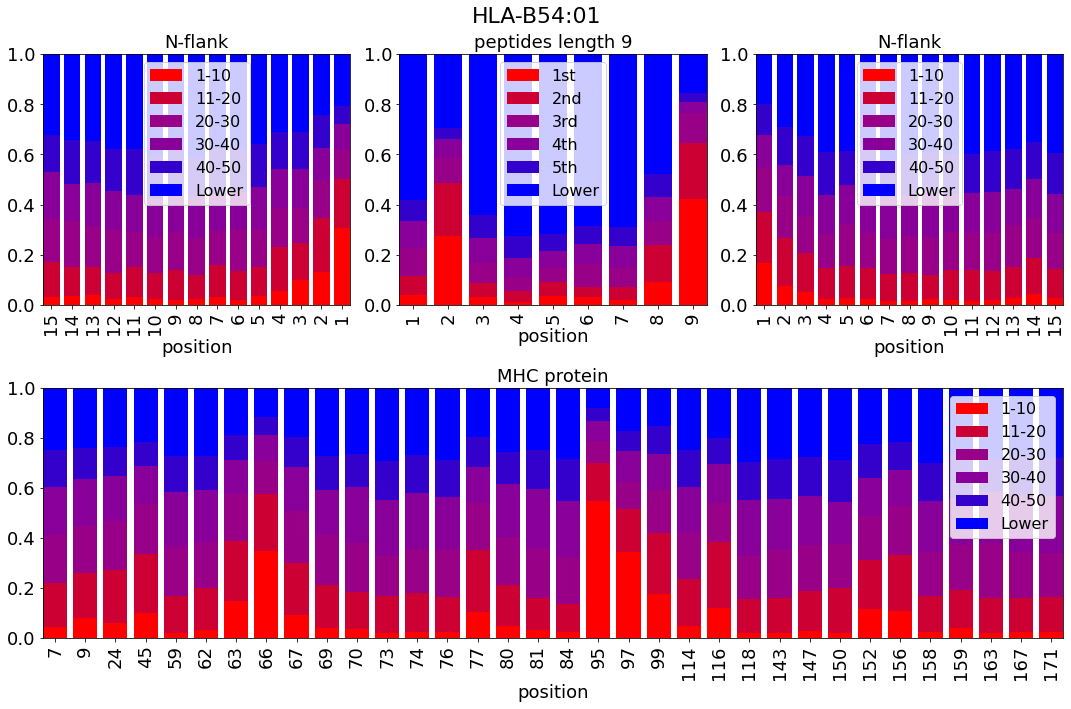

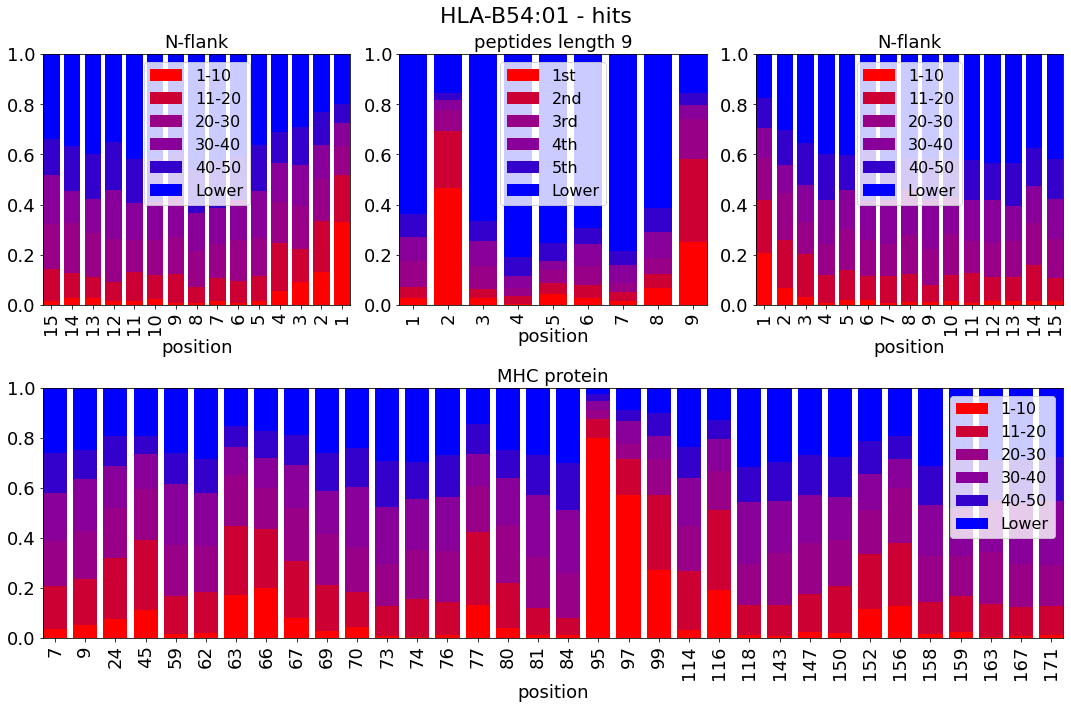

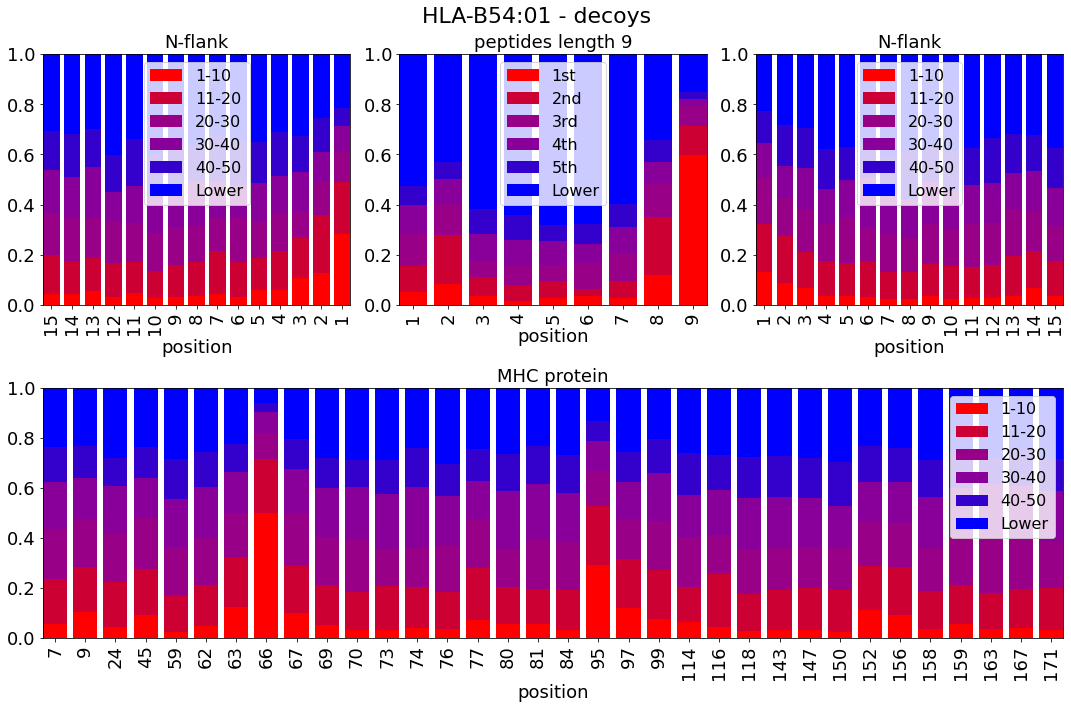

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:34:26<00:00,  5.67s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


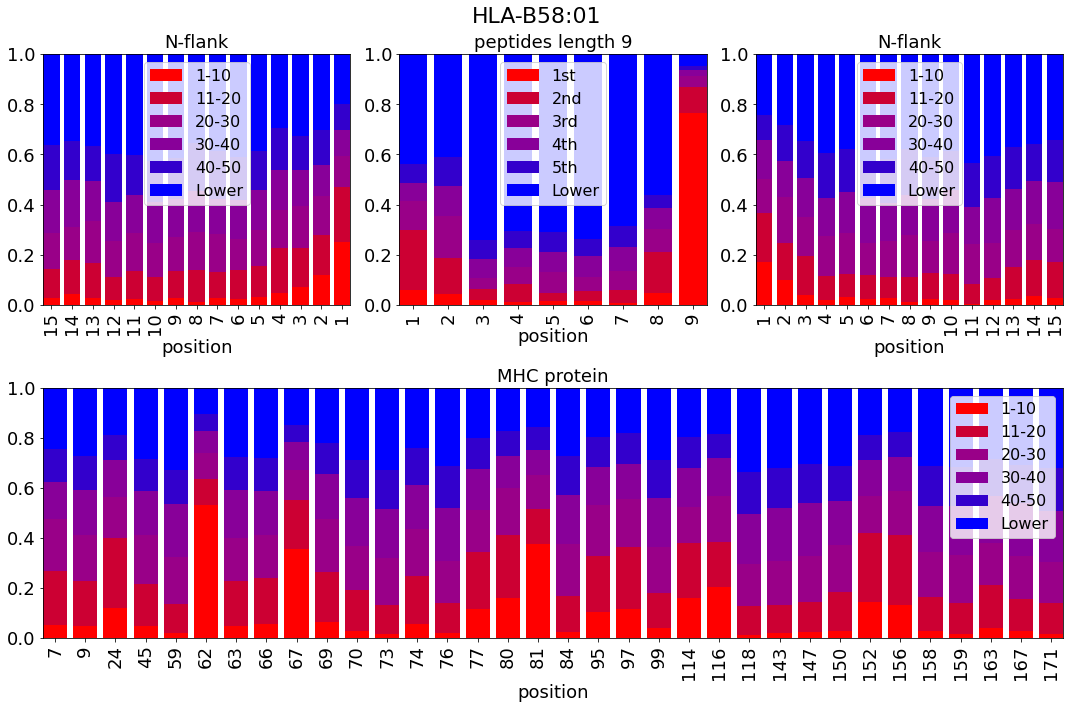

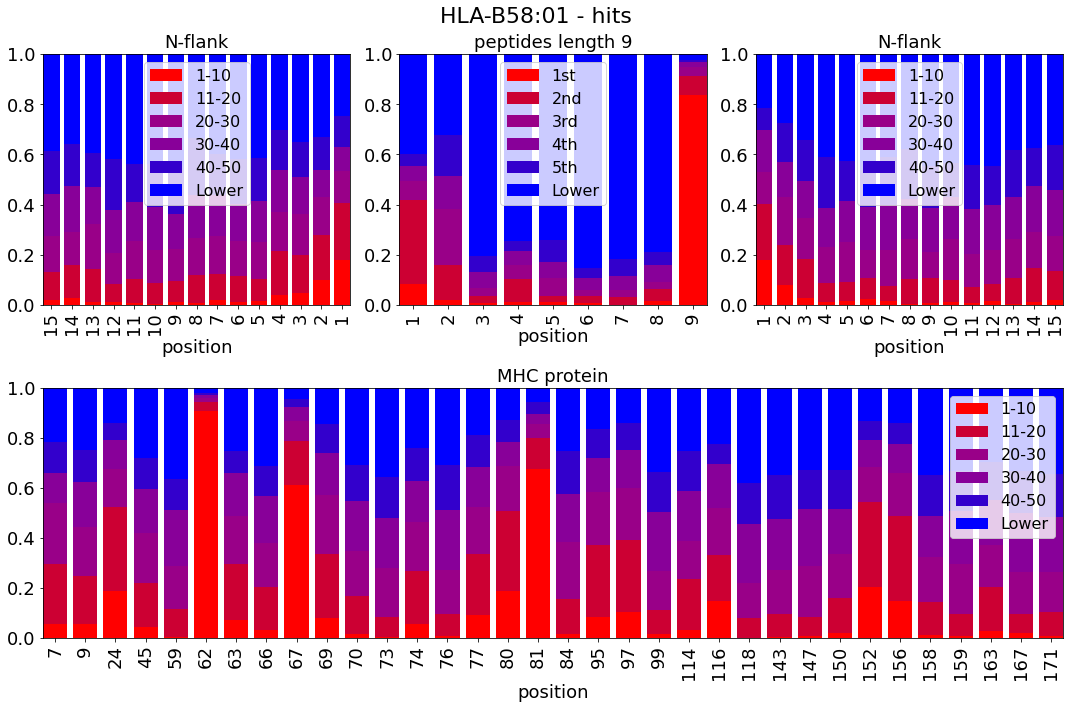

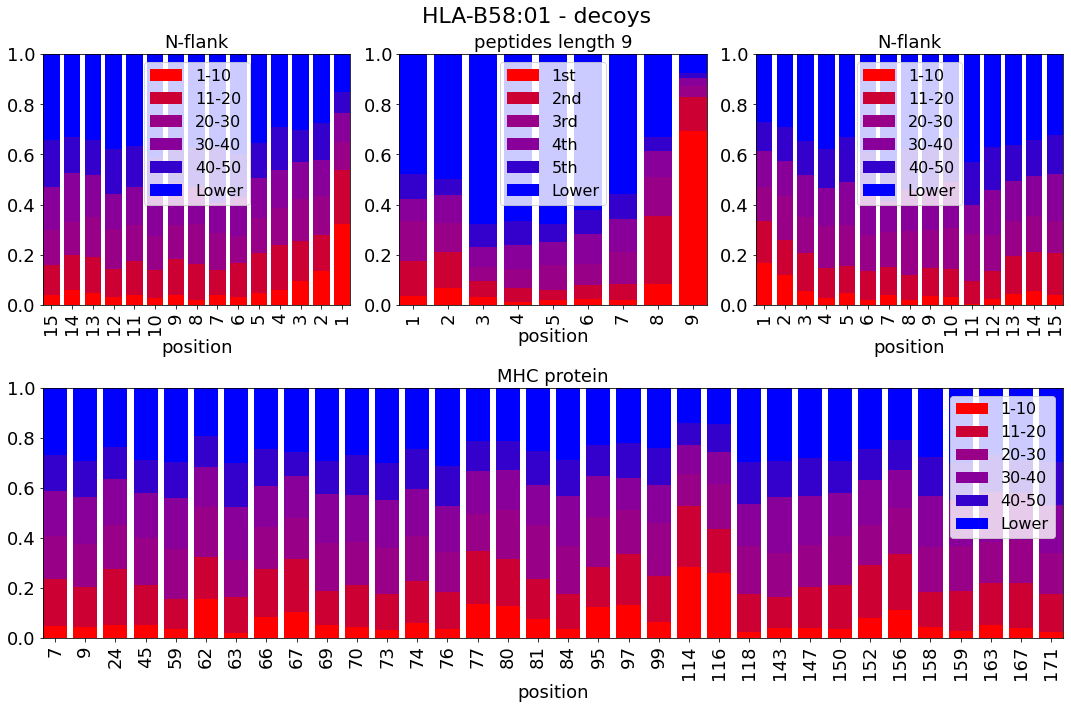

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:34:20<00:00,  5.66s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


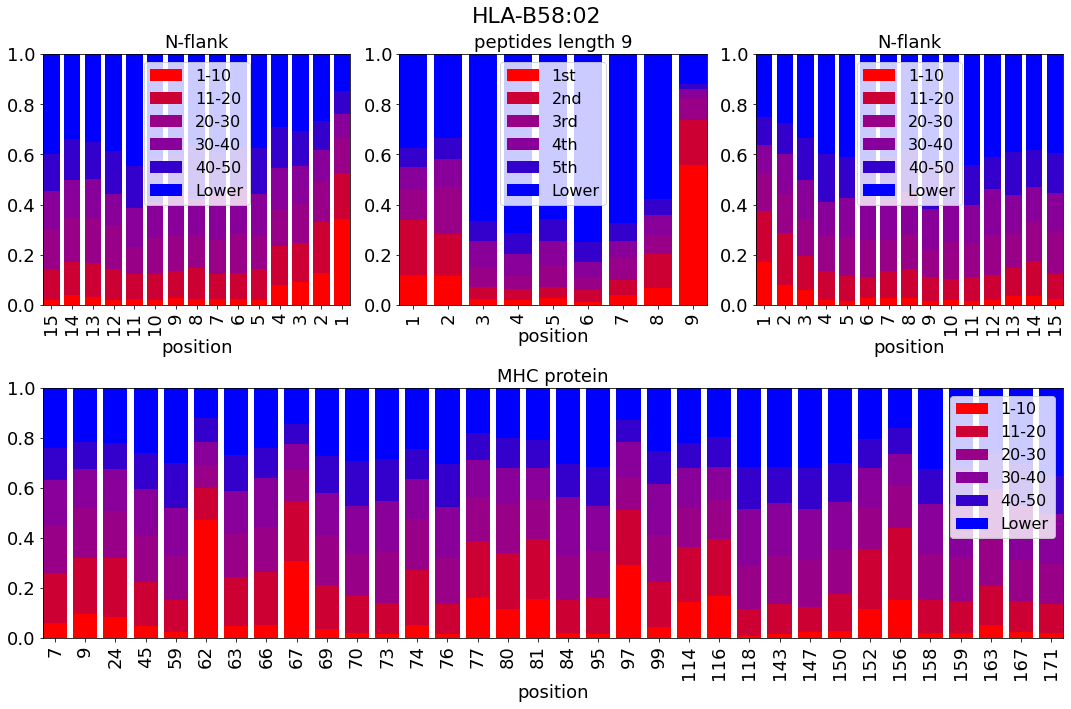

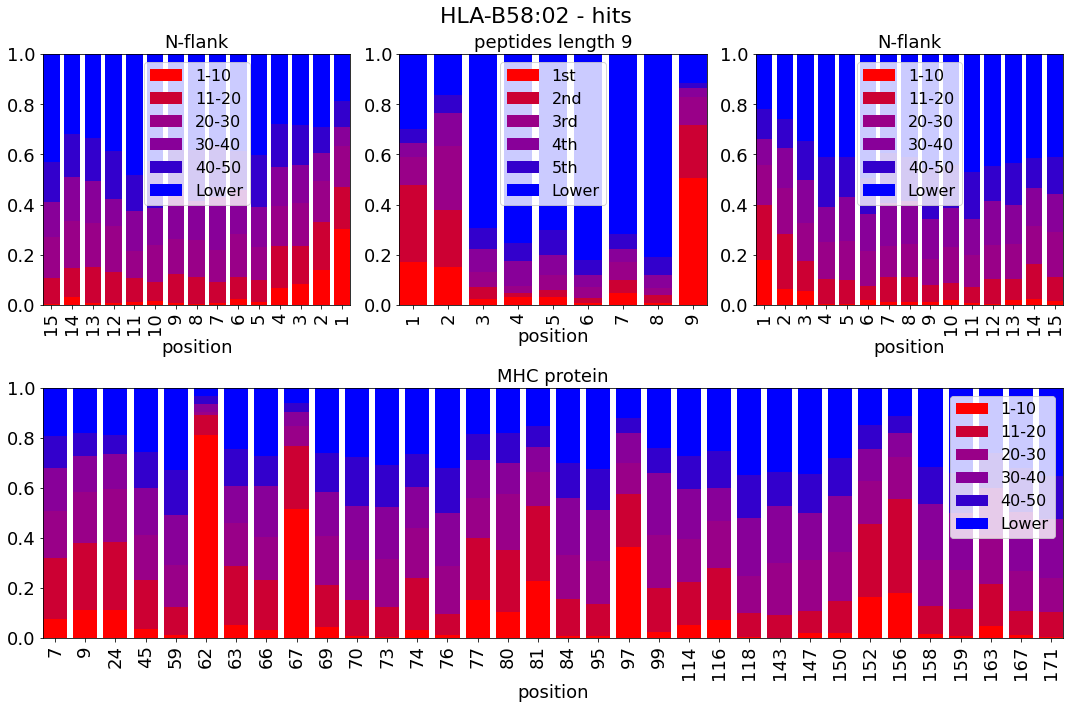

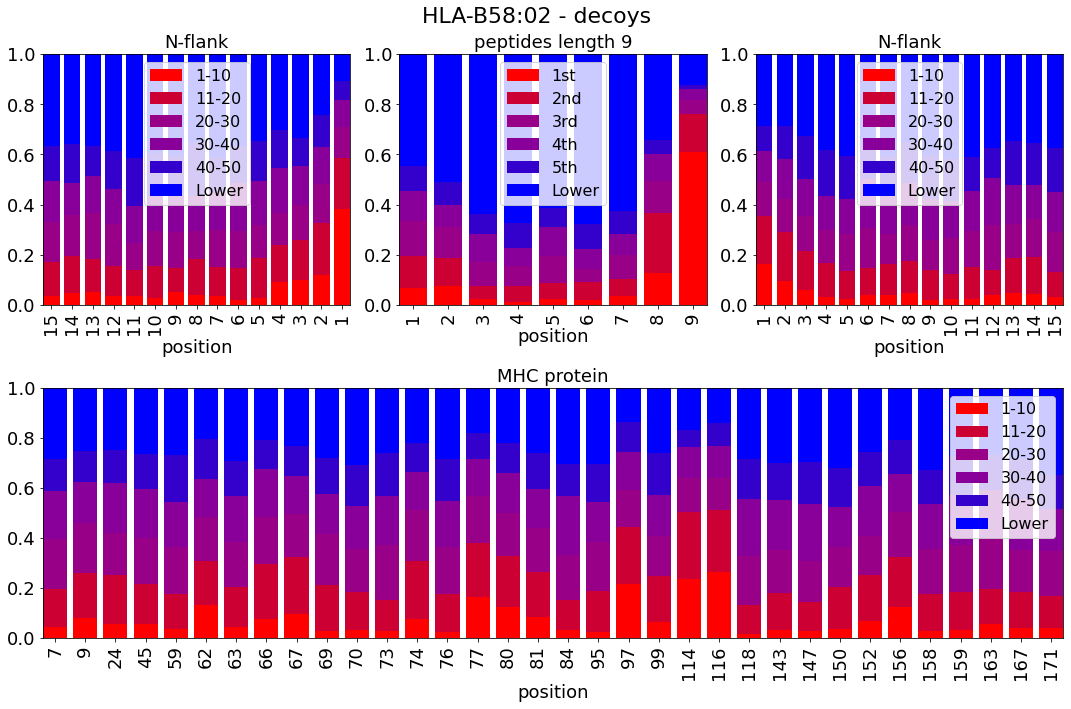

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:33:30<00:00,  5.61s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


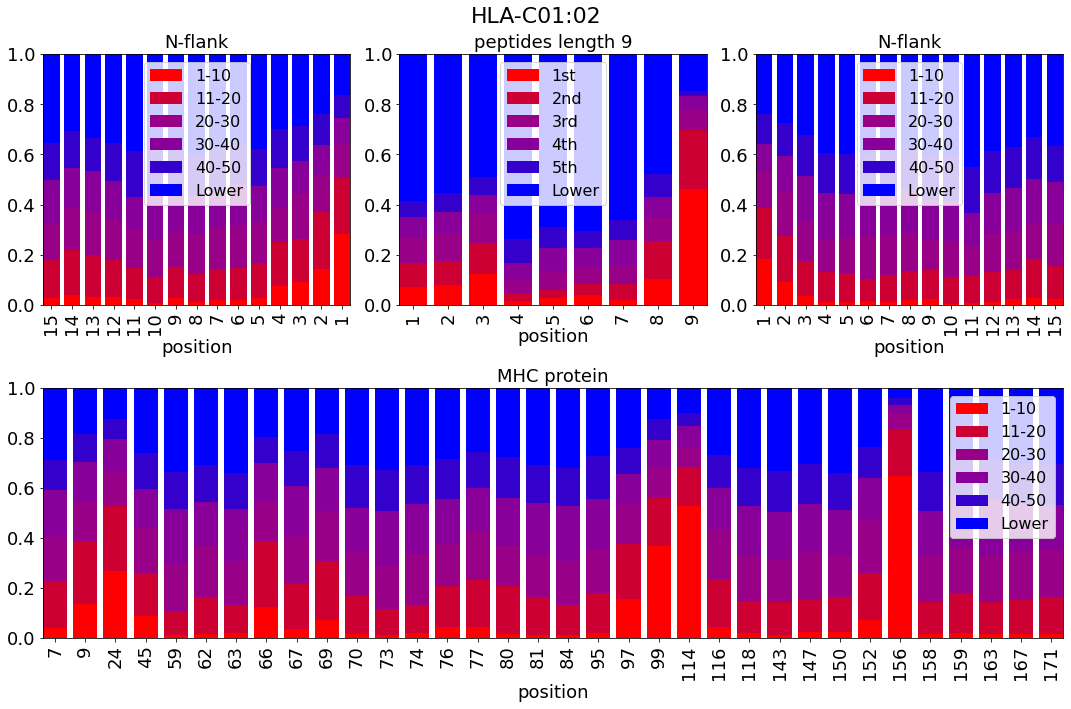

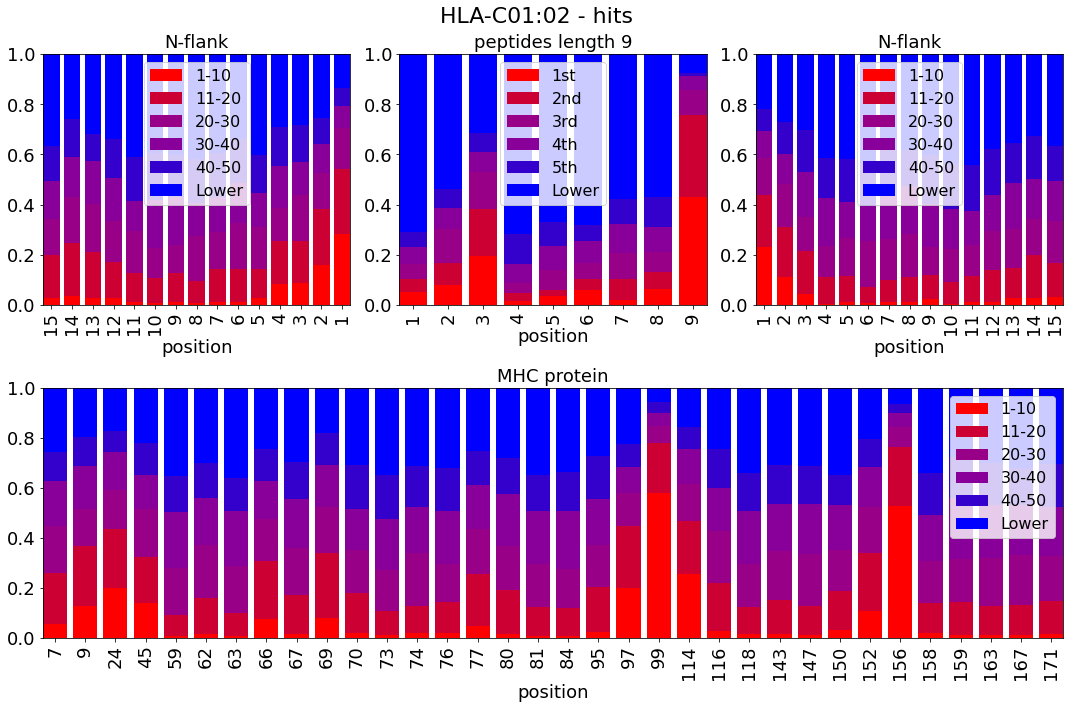

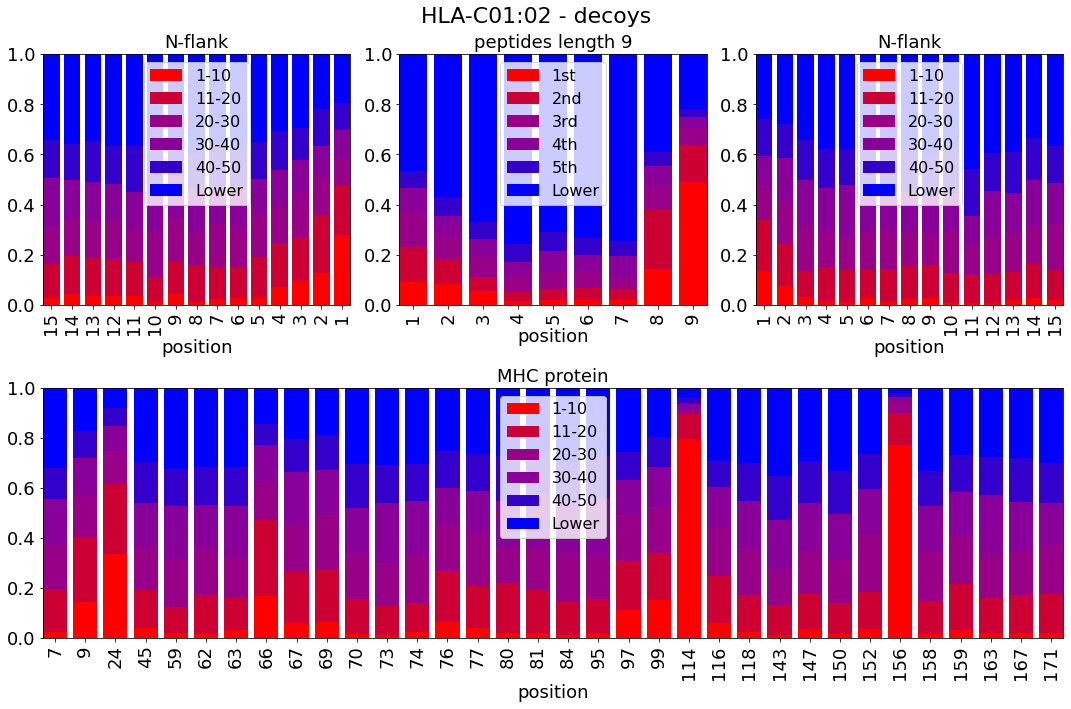

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:35:46<00:00,  5.75s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


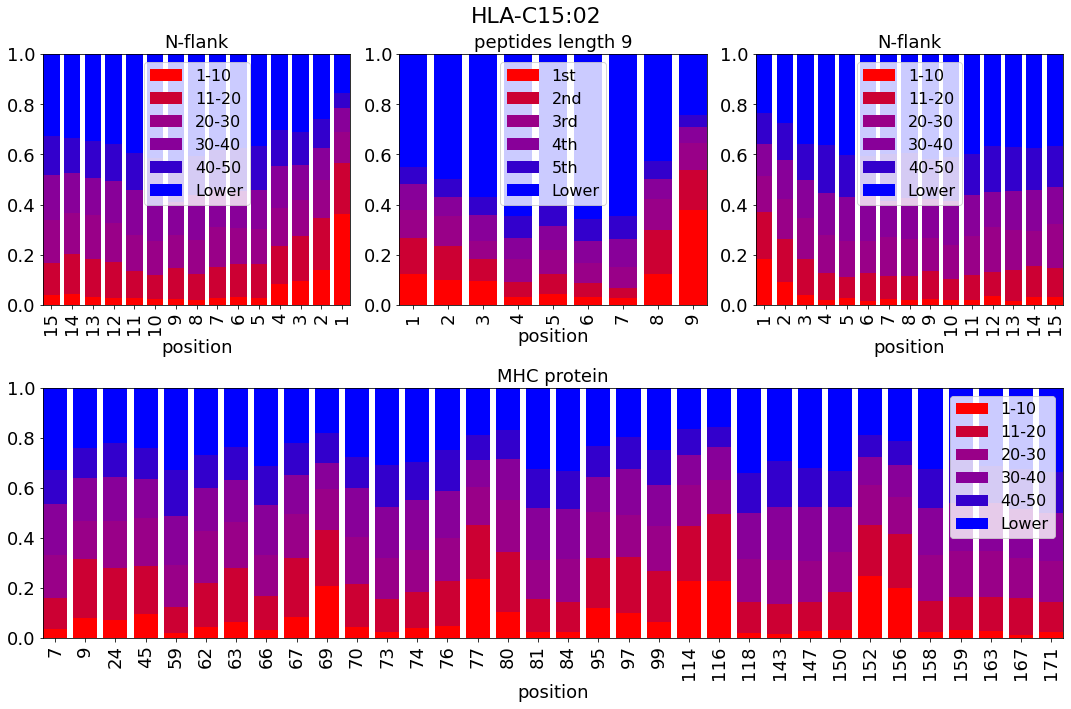

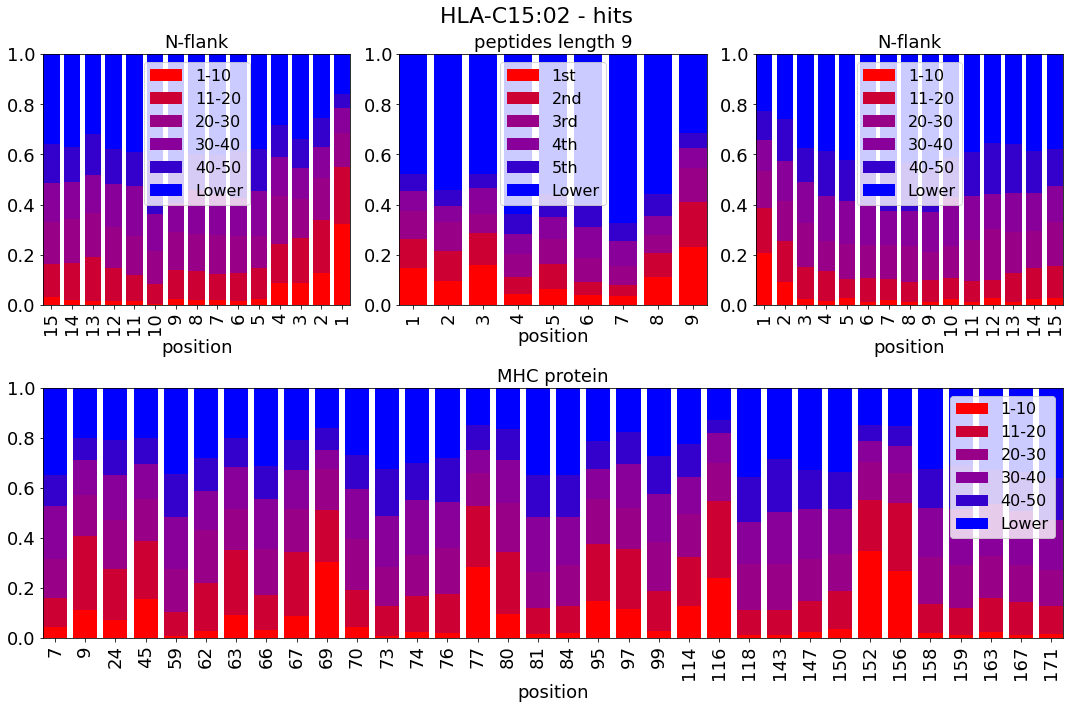

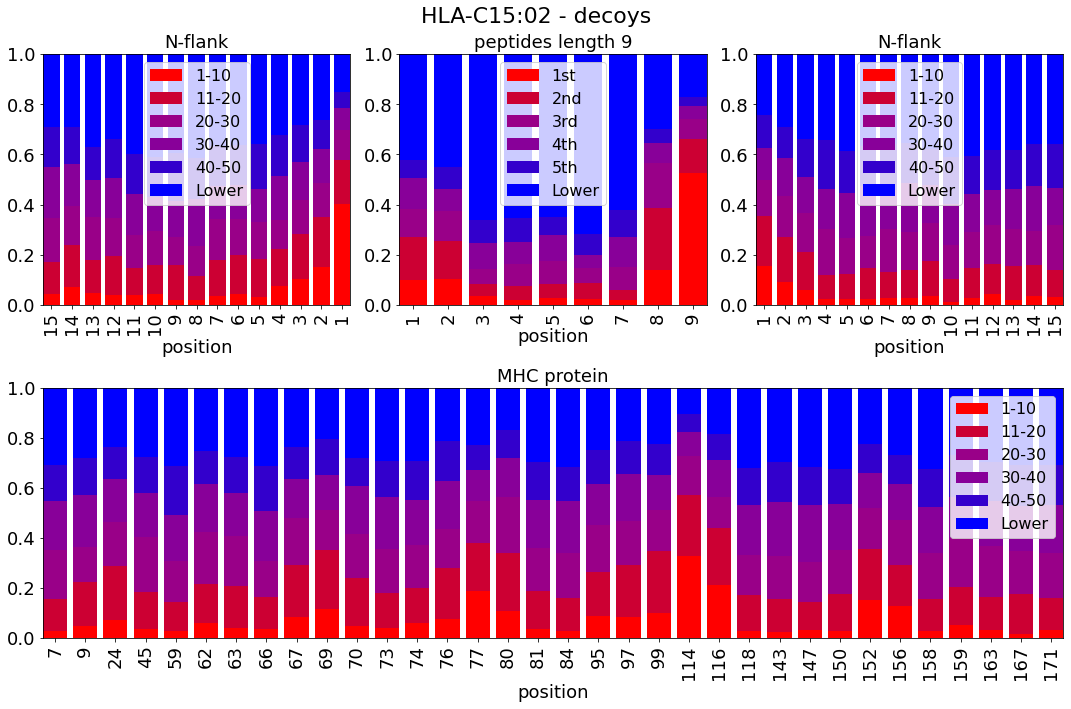

explain examples: 100%|██████████████████████████████████████████████████████████| 1000/1000 [1:34:51<00:00,  5.69s/it]
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:257: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:311: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:327: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:332: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


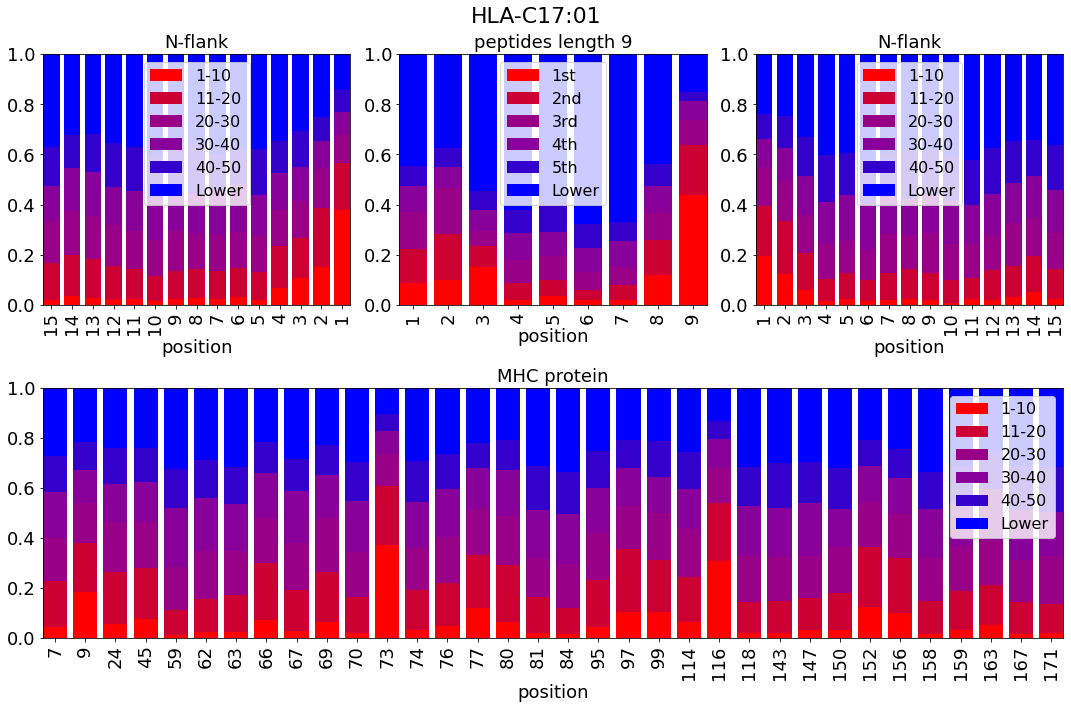

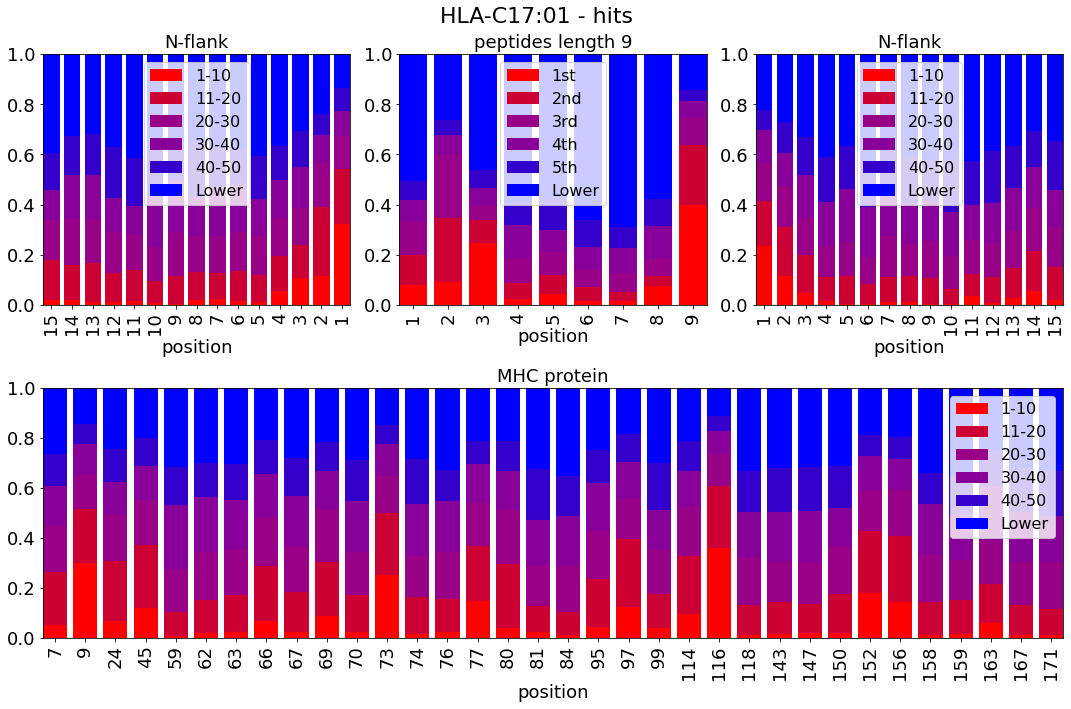

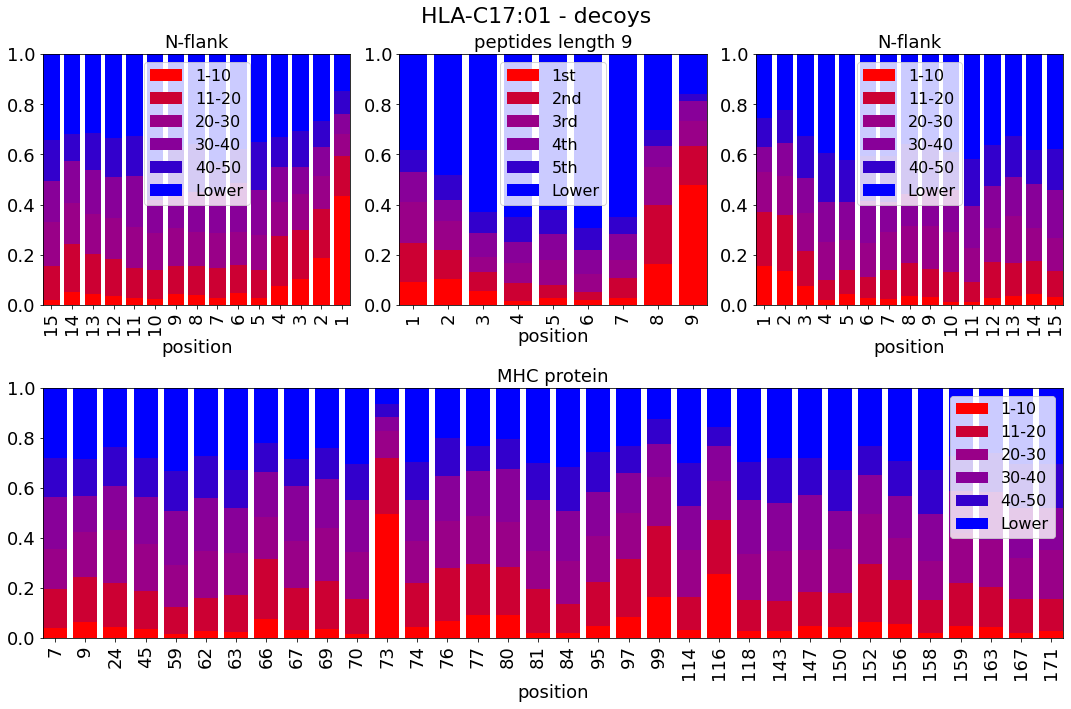

In [8]:
for mhc_allele_name in mhc_allele_names:
    lime_analysis(mhc_allele_name, examples_dict[mhc_allele_name], model, peptide_length, num_samples)

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


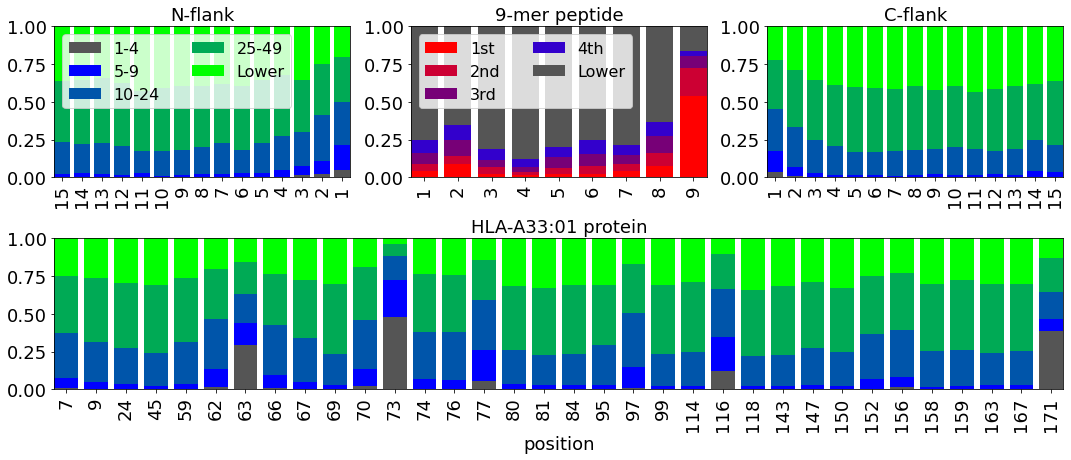

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


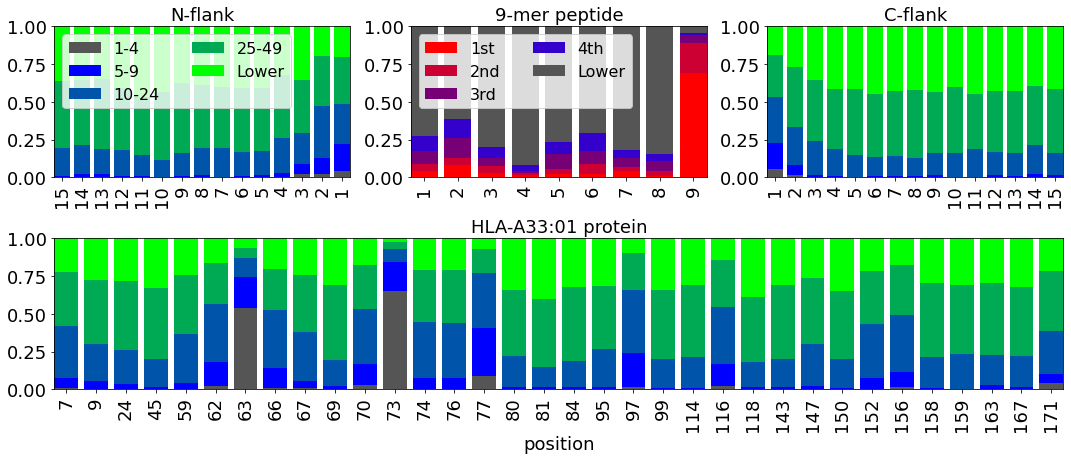

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


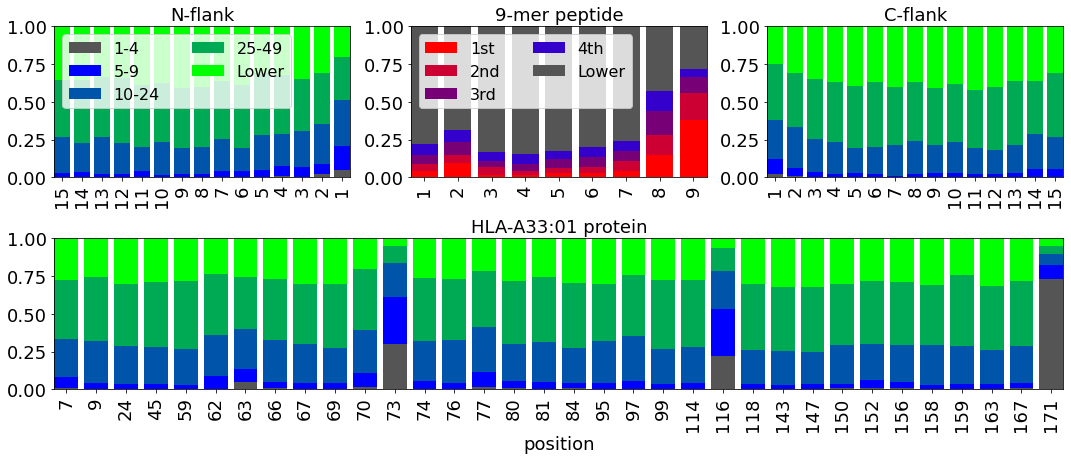

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


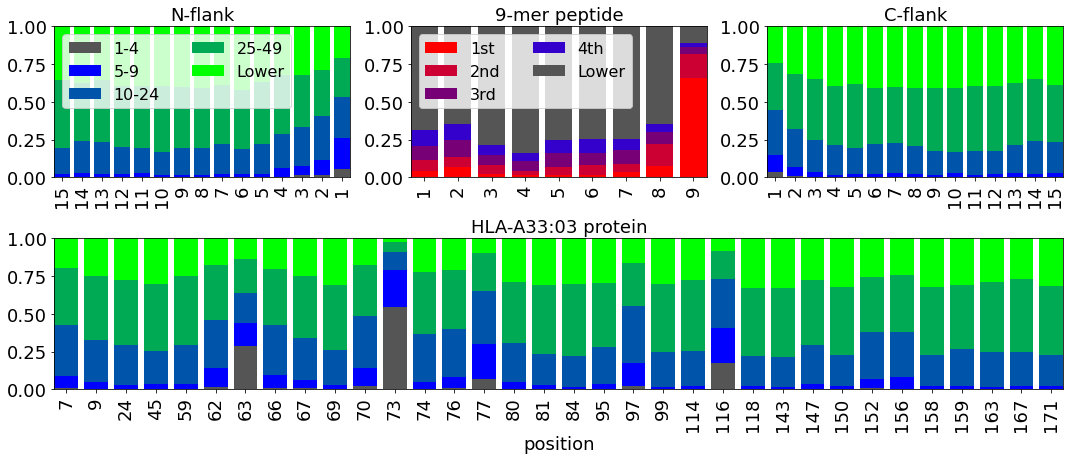

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


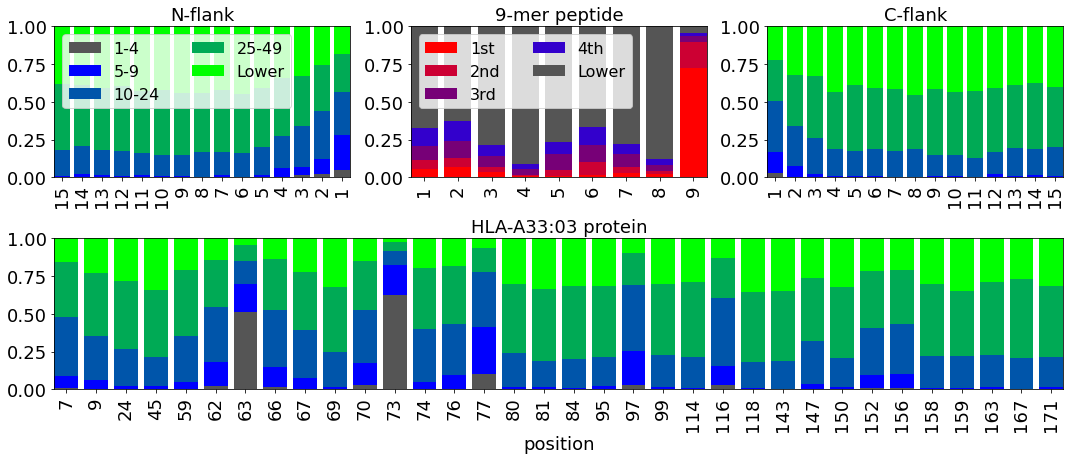

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


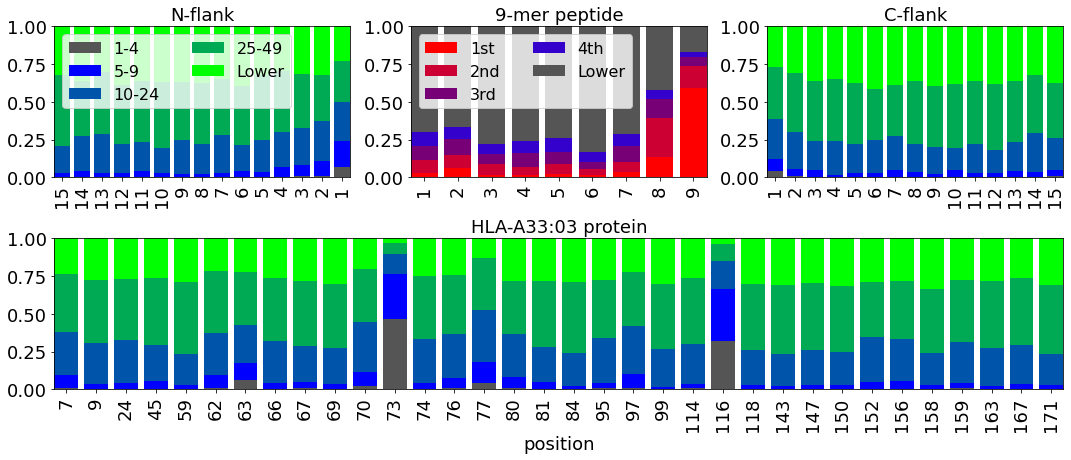

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


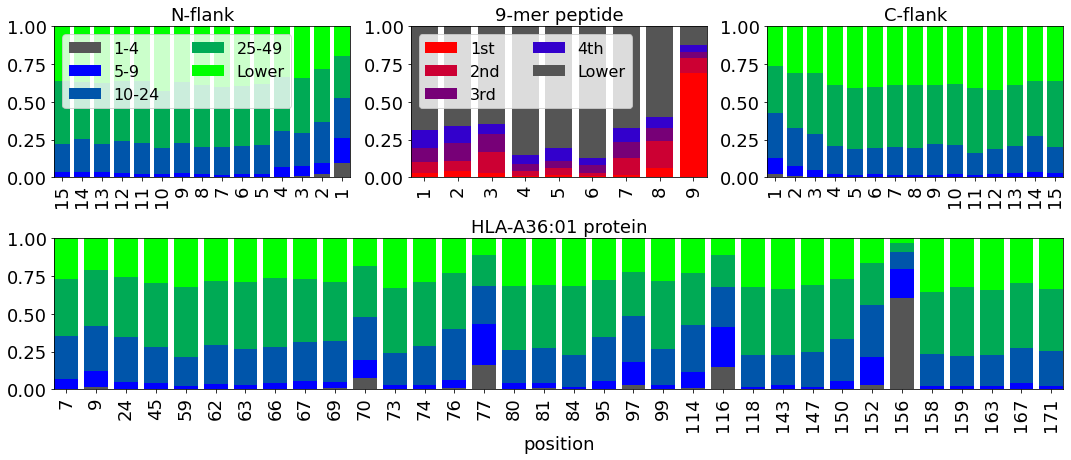

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


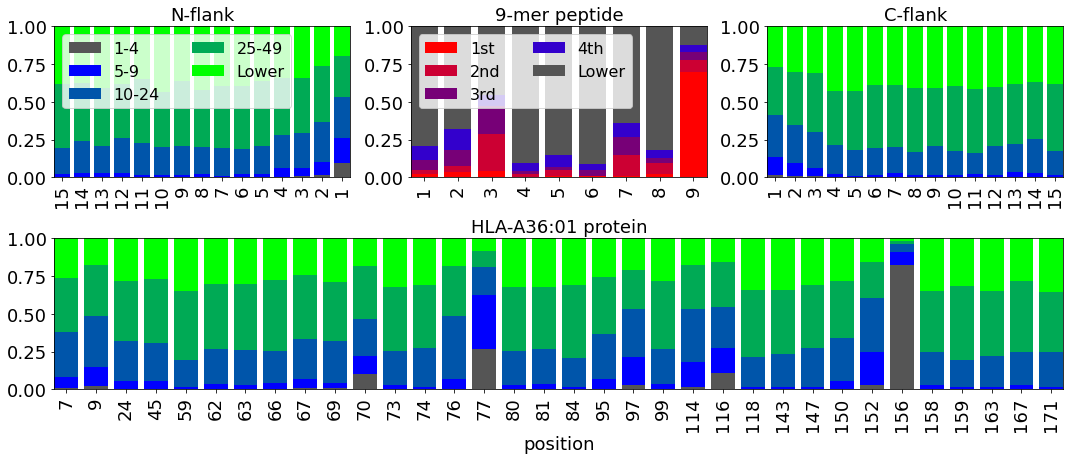

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


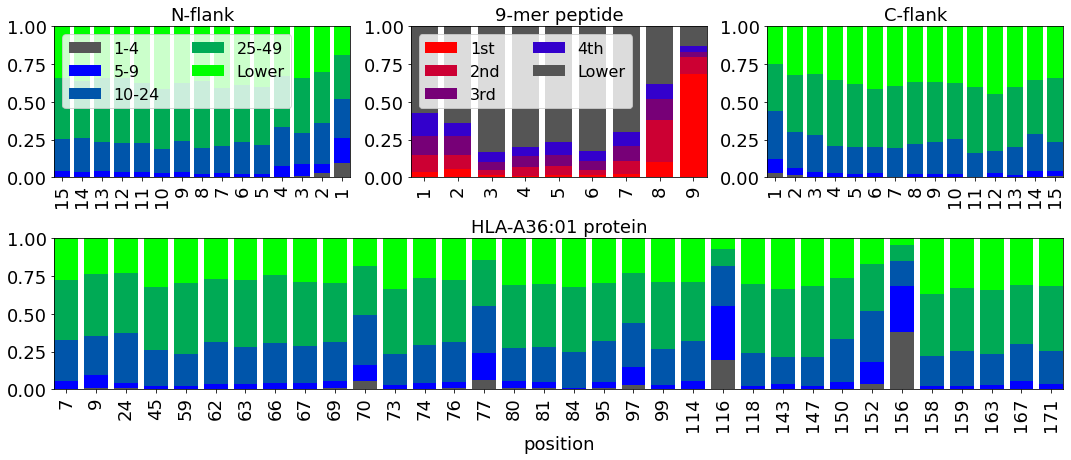

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


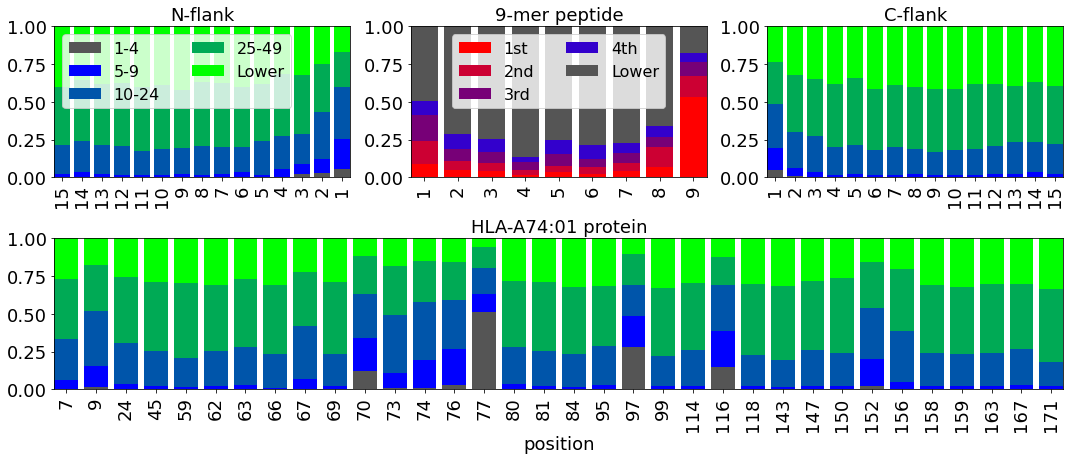

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


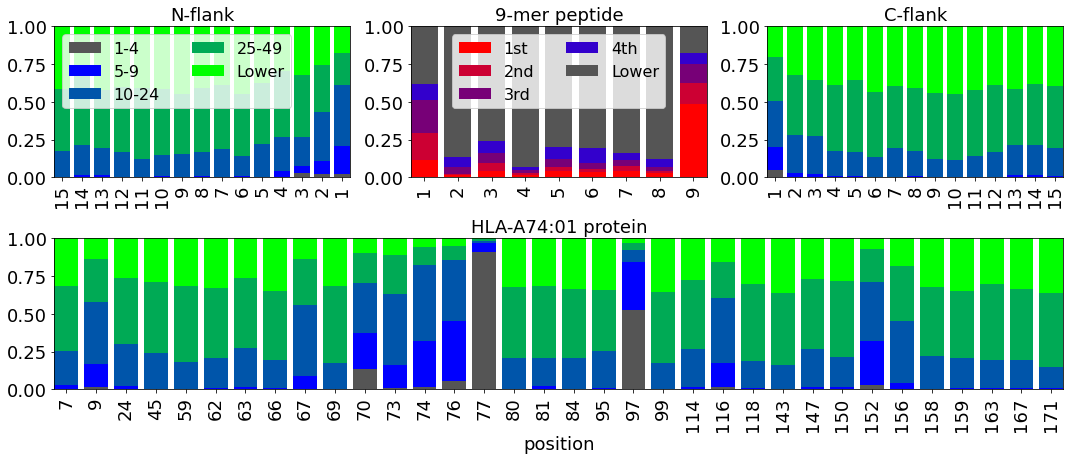

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


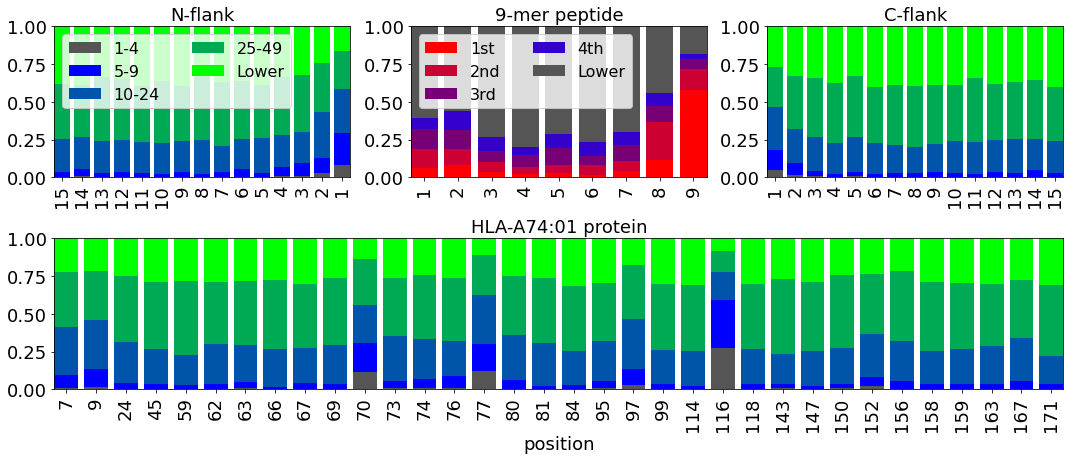

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


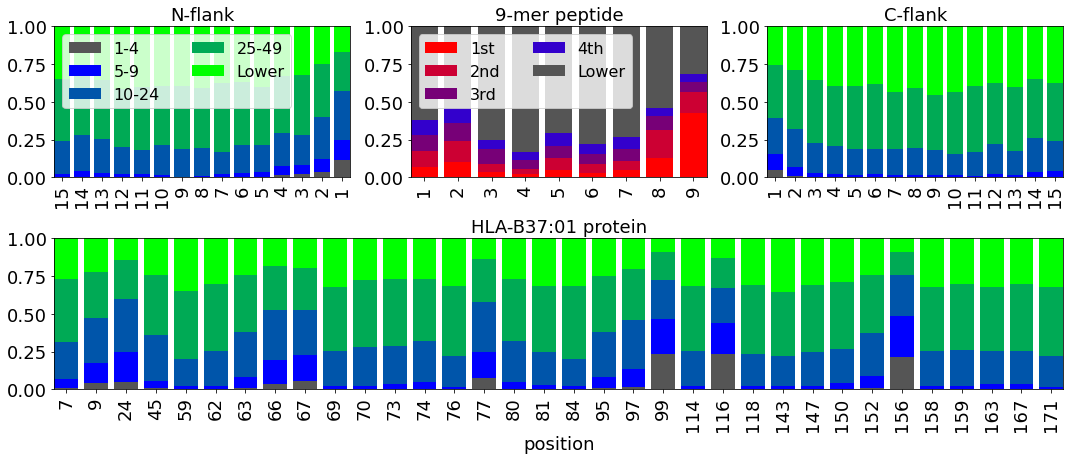

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


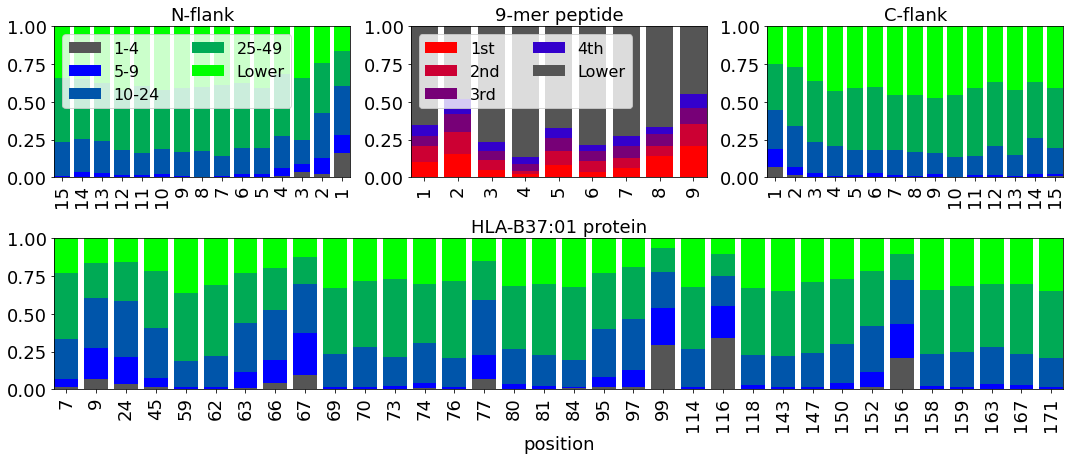

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


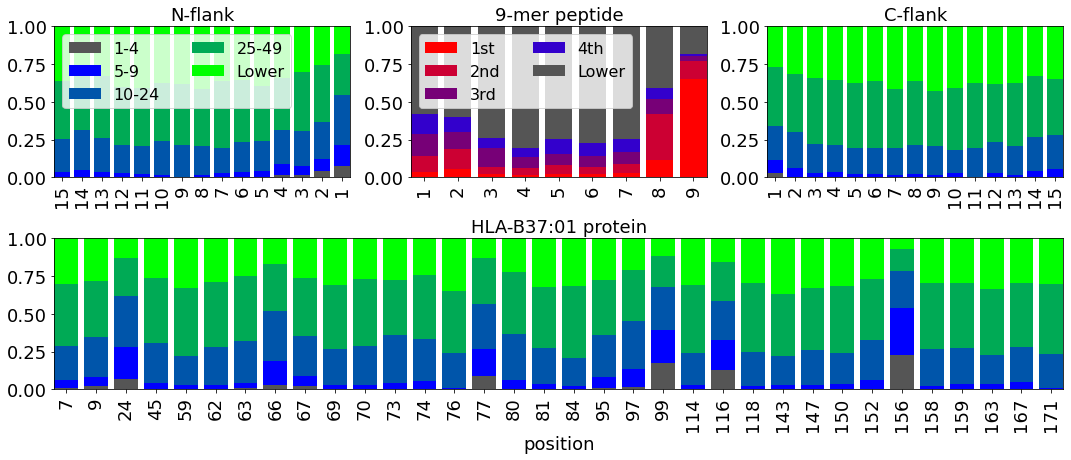

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


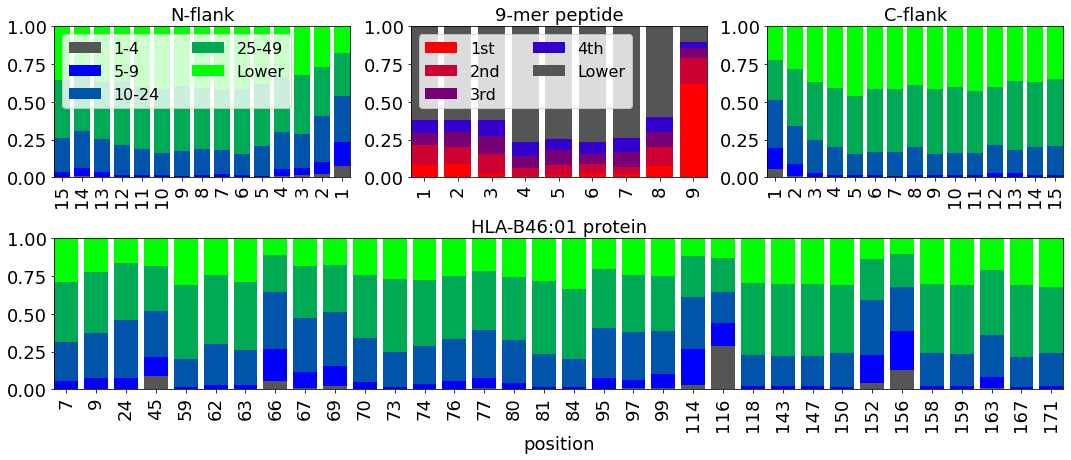

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


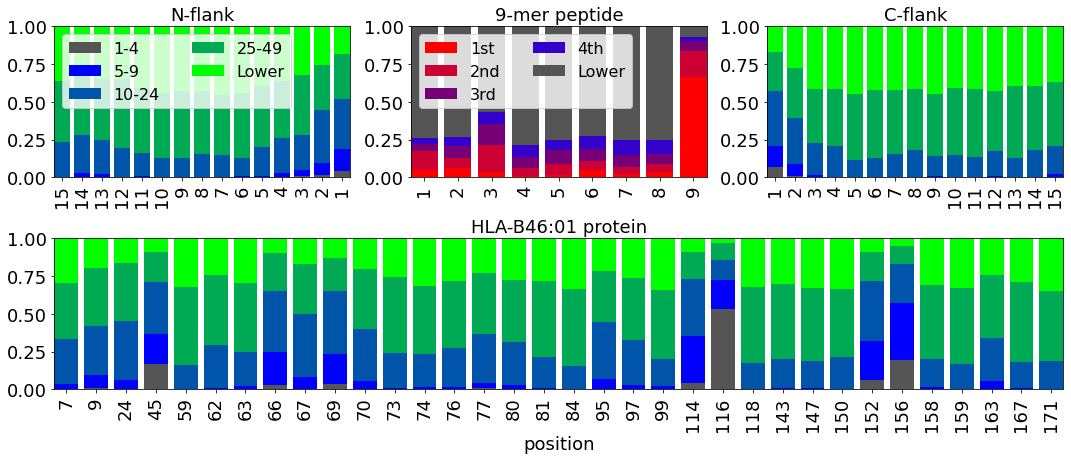

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


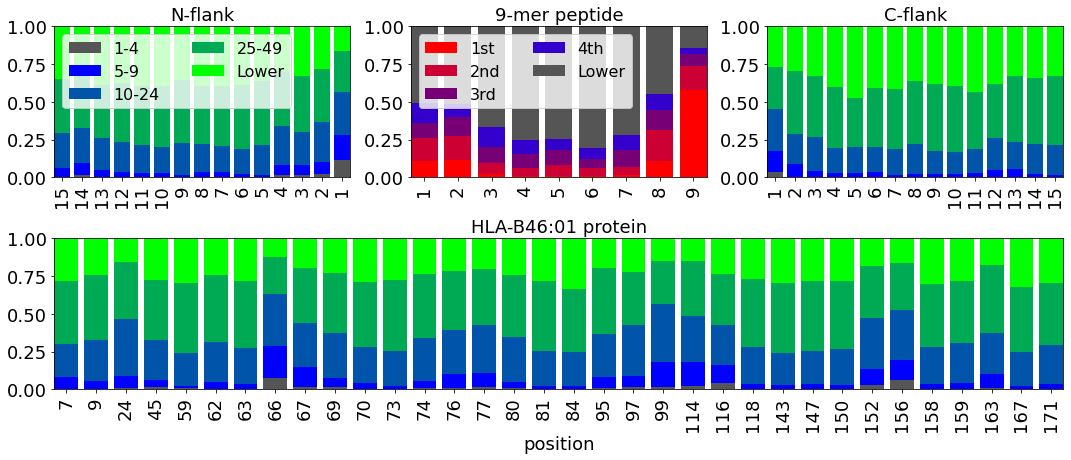

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


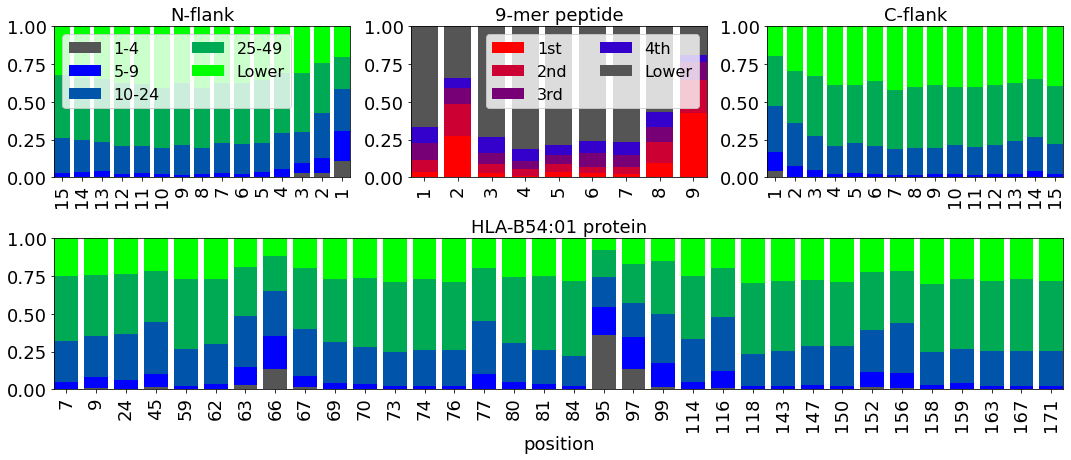

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


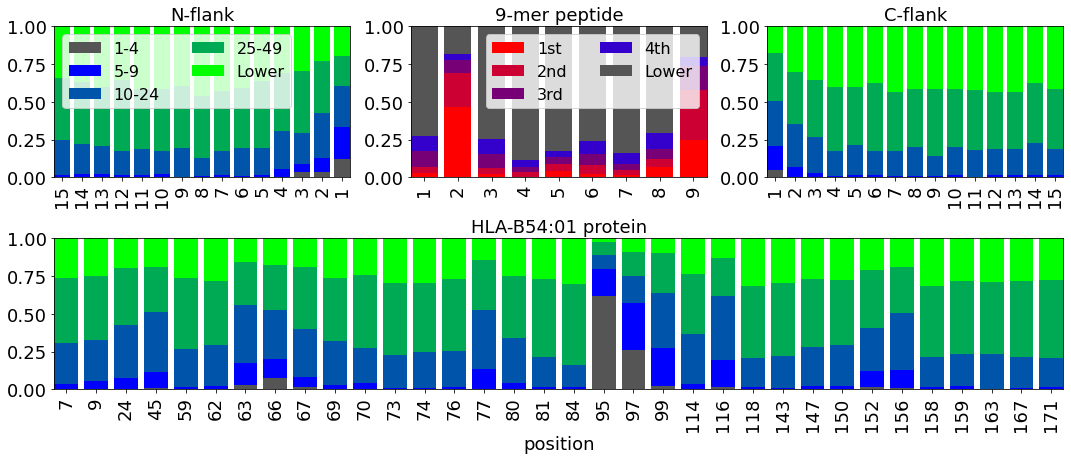

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


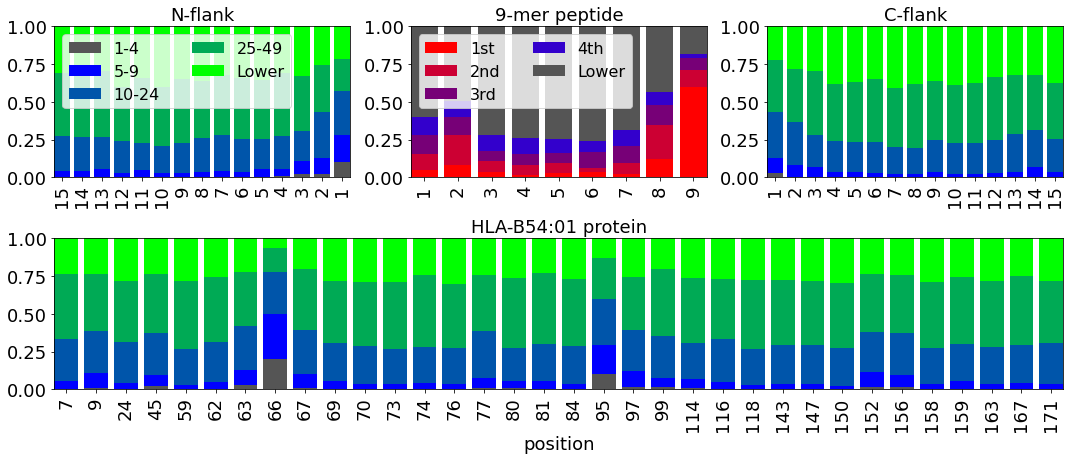

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


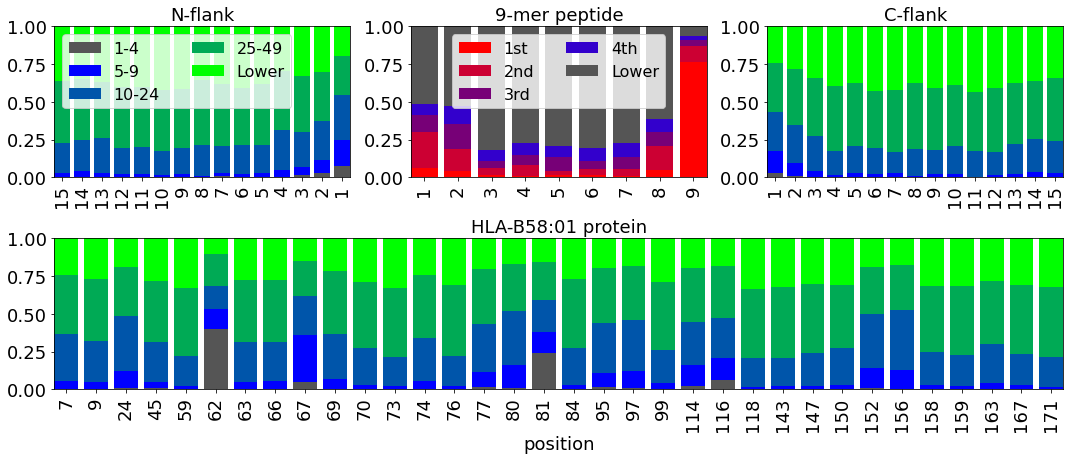

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


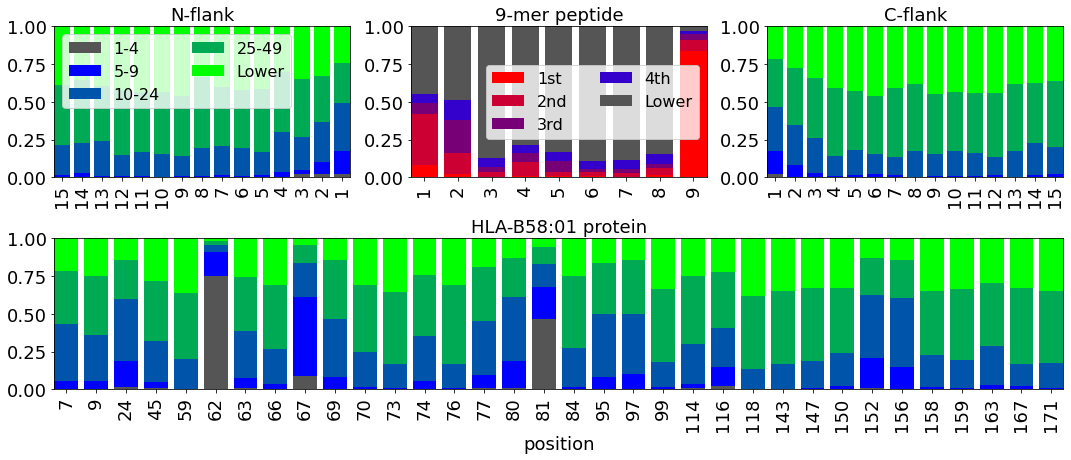

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


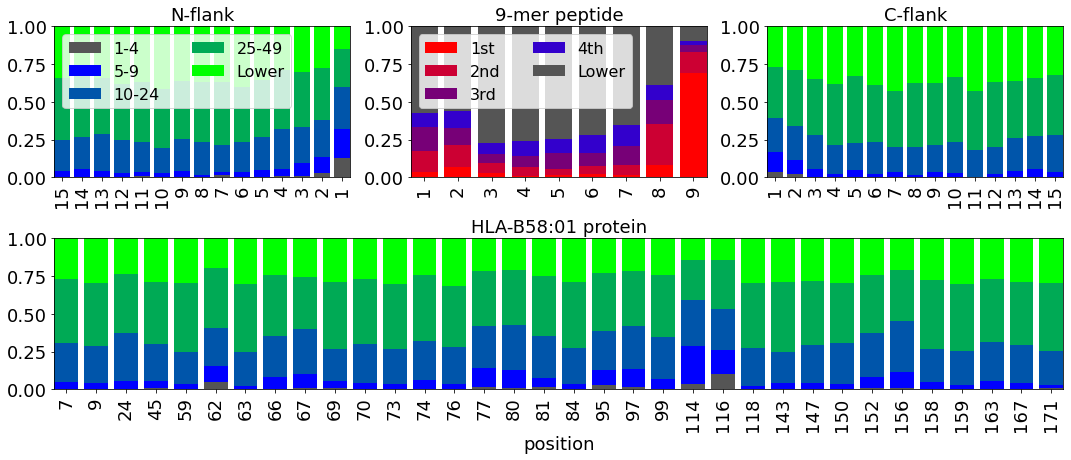

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


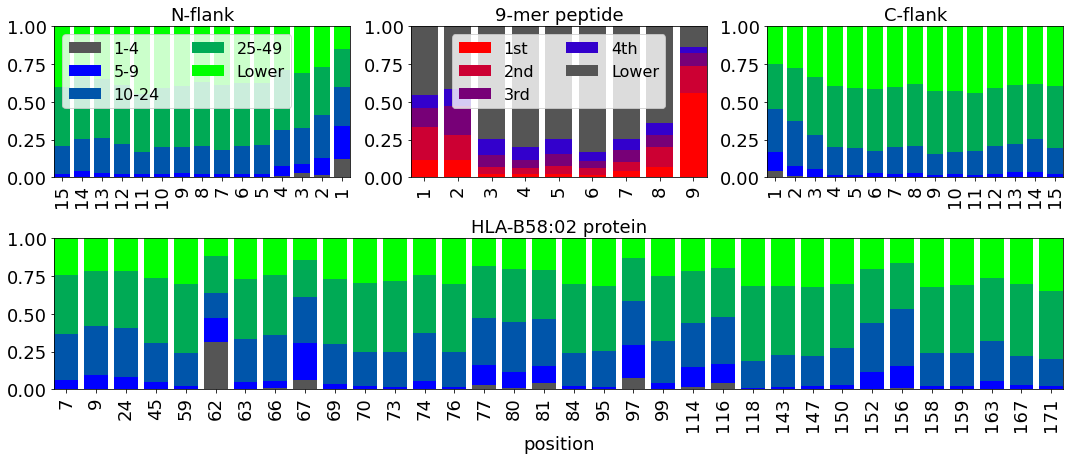

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


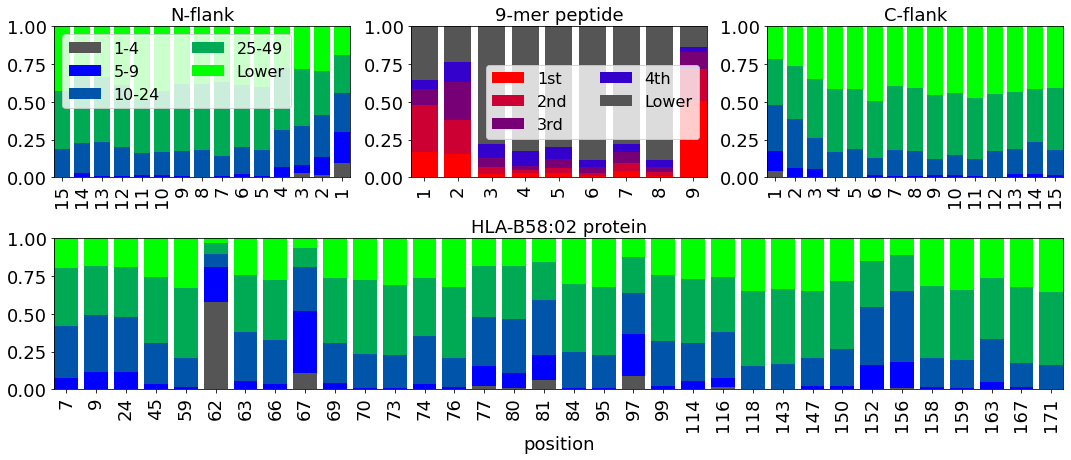

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


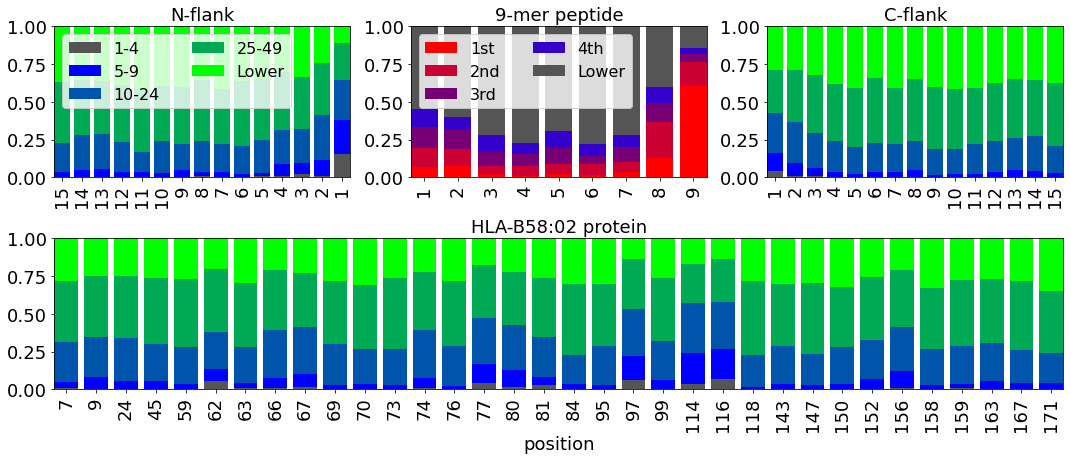

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


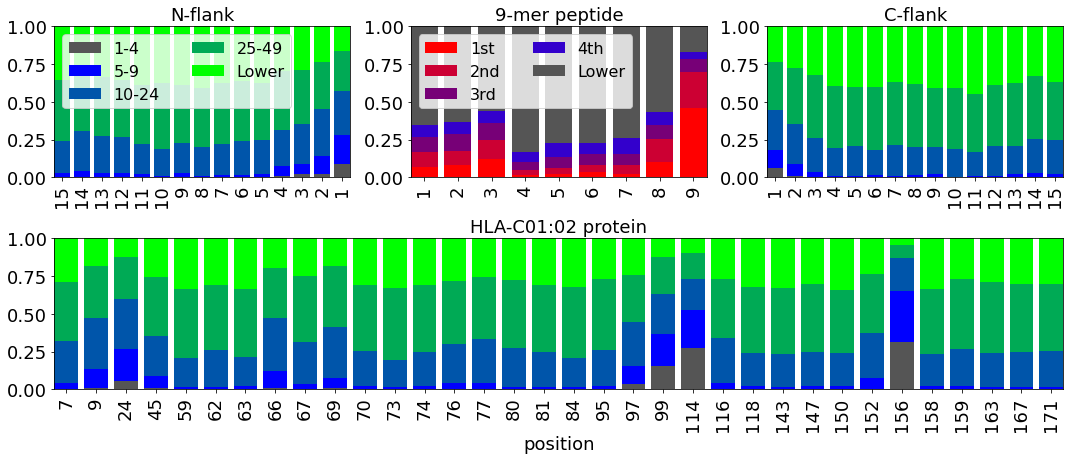

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


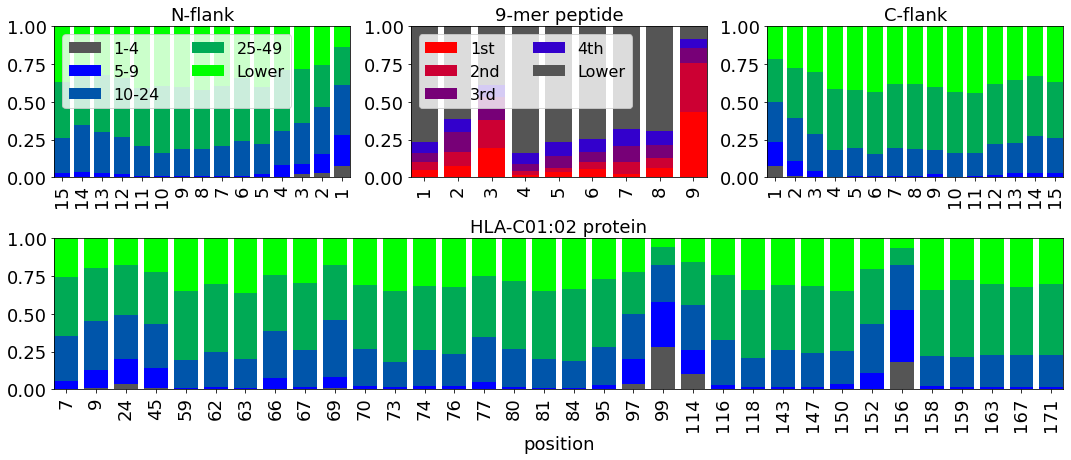

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


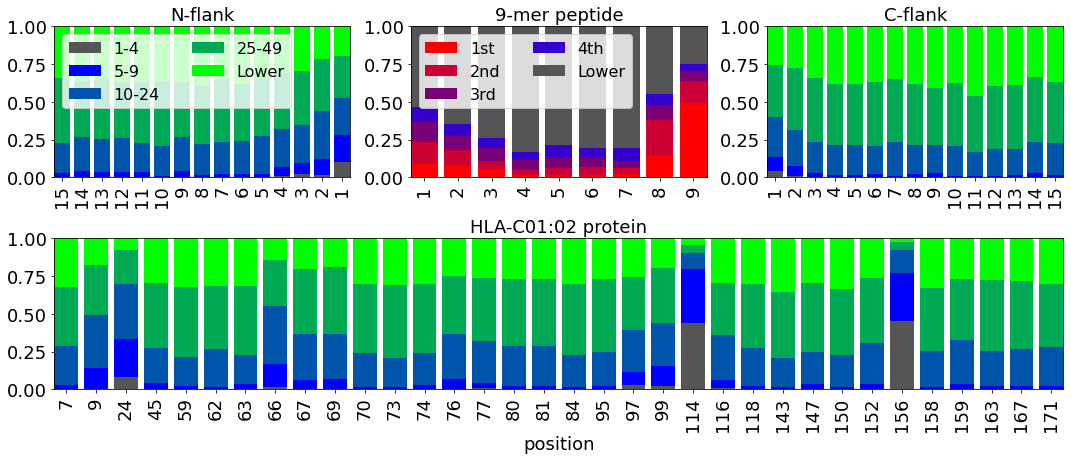

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


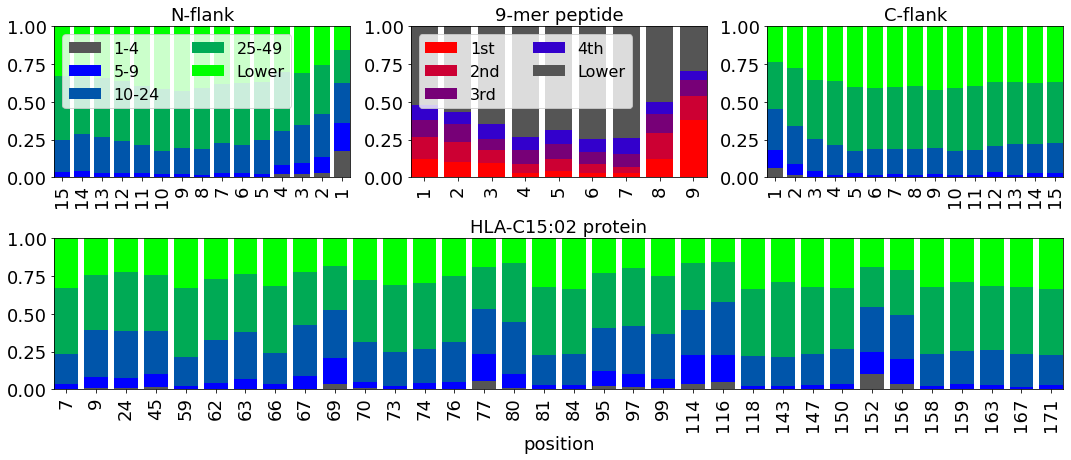

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


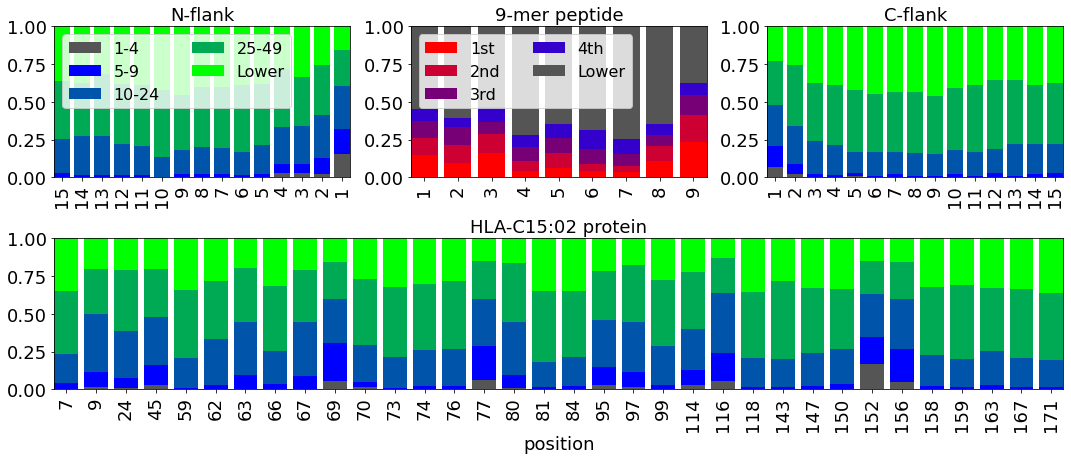

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


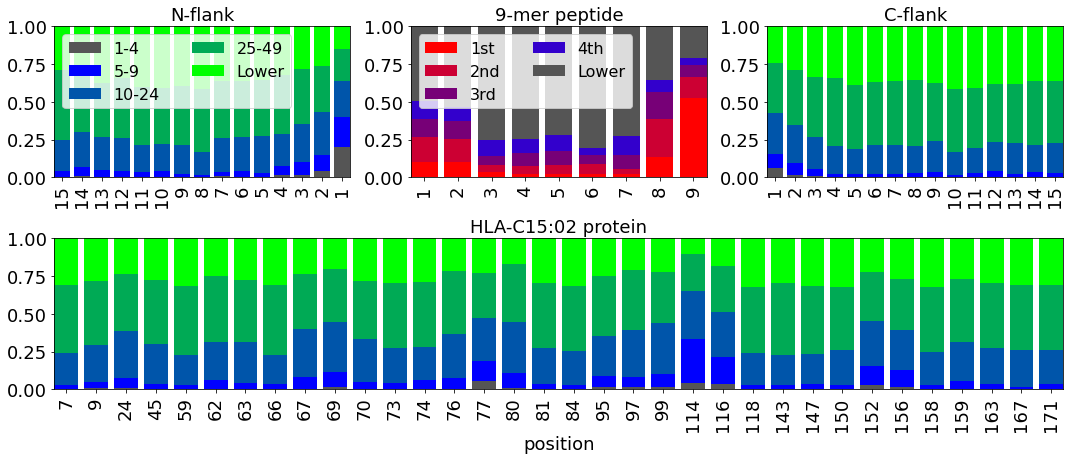

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


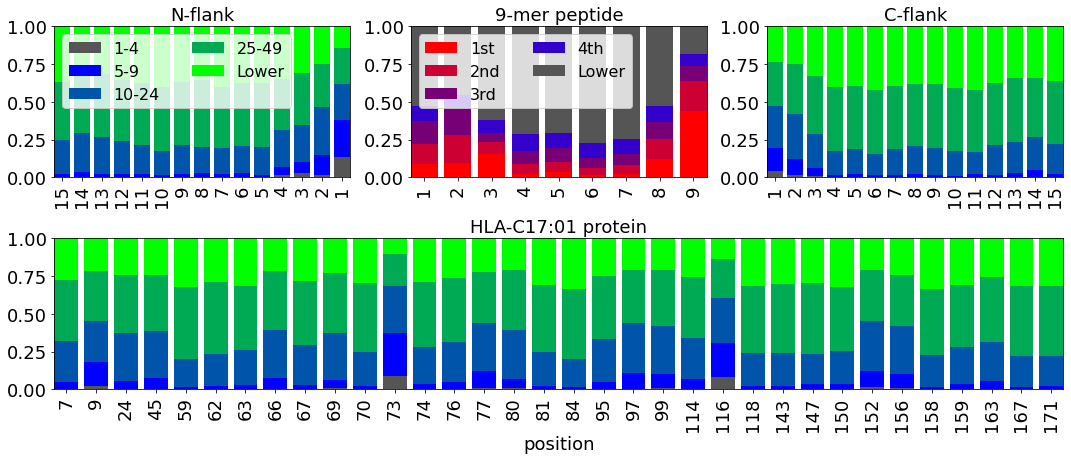

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


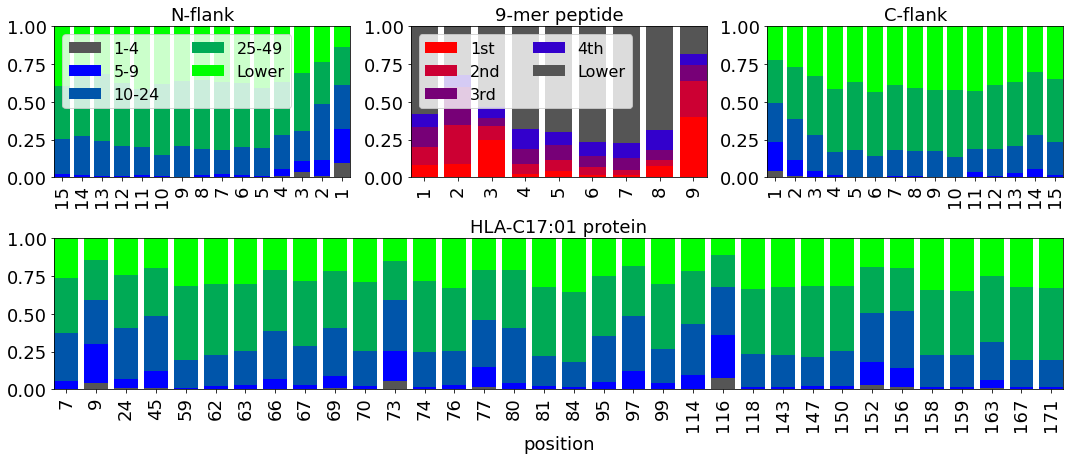

C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:326: RuntimeWarning: invalid value encountered in true_divide
  imp_prop_MHC = imp_cnt_MHC/np.sum(imp_cnt_MHC, axis=0)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:343: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(positions, rotation=90)
C:\Users\tux\Documents\MScProject\epitope\pMHC\interpret\lime_based.py:351: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


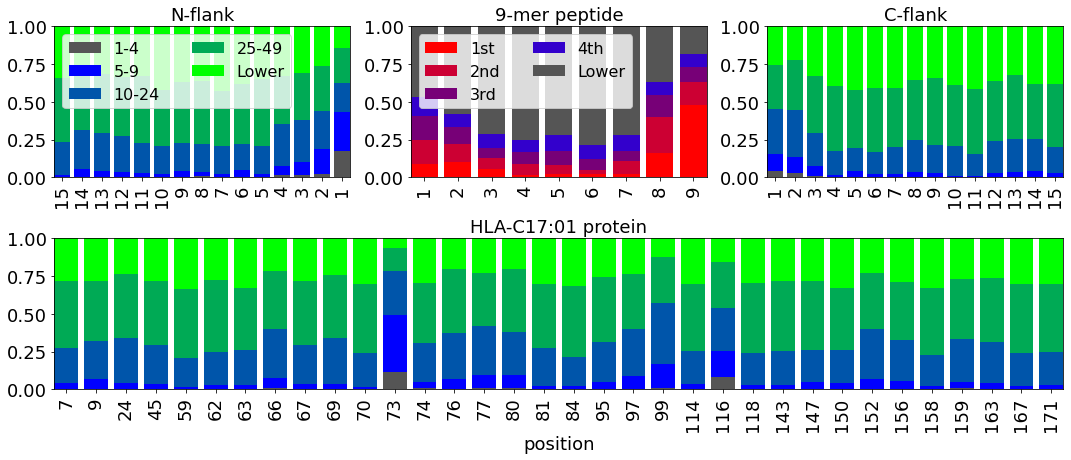

In [7]:
for mhc_allele_name in examples_dict.keys():
    with open(f"{pMHC.OUTPUT_FOLDER}{SEP}lime{SEP}{mhc_allele_name.replace(':', '')}_importances.pickle", "rb") as f:
        imp_cnt_all, imp_cnt_hits, imp_cnt_decoys = pickle.load(f)

    stacked_bar_charts(mhc_allele_name, "", model, imp_cnt_all["N-flank"], imp_cnt_all["peptide"], imp_cnt_all["C-flank"], imp_cnt_all["MHC"])
    stacked_bar_charts(mhc_allele_name, "-hits", model, imp_cnt_hits["N-flank"], imp_cnt_hits["peptide"], imp_cnt_hits["C-flank"], imp_cnt_hits["MHC"])
    stacked_bar_charts(mhc_allele_name, "-decoys", model, imp_cnt_decoys["N-flank"], imp_cnt_decoys["peptide"], imp_cnt_decoys["C-flank"], imp_cnt_decoys["MHC"])
